#### STEP 1:  Import dataset by sql query file to your local computer and create connection between your sql and  python  

In [116]:
# Import library untuk SQLite
import sqlite3

In [117]:
# Hubungkan ke database SQLite (sesui letak dimana data disimpan)
conn = sqlite3.connect(r"D:\Growia\Modul 9\Beginner Level\foo.db")

In [118]:
# Buat cursor untuk menjalankan perintah SQL
cursor = conn.cursor()

In [119]:
# Eksekusi query untuk mendapatkan daftar tabel dalam database
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

In [120]:
# Ambil hasil query dan tampilkan nama tabel yang ada
tables = cursor.fetchall()
print("Tables:", tables)

Tables: [('olist_customers_dataset',), ('olist_geolocation_dataset',), ('olist_orders_dataset',), ('olist_order_items_dataset',), ('olist_order_payments_dataset',), ('olist_order_reviews_dataset',), ('olist_products_dataset',), ('olist_sellers_dataset',), ('product_category_name_translation',)]


### STEP 2: Import library needed ( pandas, matplotlib, and seaborn)

In [121]:
# Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### STEP 3: Merge the dataset using their key connection based on dataset framework above

In [122]:
# Load dataset dari database SQLite 
# Tujuannya untuk mengambil data yang tersimpan di dalam database agar bisa dianalisis atau diolah lebih lanjut menggunakan Python
df_orders = pd.read_sql("SELECT * FROM olist_orders_dataset", conn)
df_order_items = pd.read_sql("SELECT * FROM olist_order_items_dataset", conn)
df_customers = pd.read_sql("SELECT * FROM olist_customers_dataset", conn)
df_sellers = pd.read_sql("SELECT * FROM olist_sellers_dataset", conn)
df_products = pd.read_sql("SELECT * FROM olist_products_dataset", conn)
df_order_payments = pd.read_sql("SELECT * FROM olist_order_payments_dataset", conn)
df_order_reviews = pd.read_sql("SELECT * FROM olist_order_reviews_dataset", conn)
df_geolocation = pd.read_sql("SELECT * FROM olist_geolocation_dataset", conn)
df_product_category_name_translation = pd.read_sql("SELECT * FROM product_category_name_translation", conn)

In [123]:
# Cek kolom dari setiap tabel
tables = {
    "orders": df_orders,
    "order_items": df_order_items,
    "customers": df_customers,
    "sellers": df_sellers,
    "products": df_products,
    "order_payments": df_order_payments,
    "order_reviews": df_order_reviews,
    "geolocation": df_geolocation,
    "product_category_name_translation": df_product_category_name_translation
}

In [124]:
for table_name, df in tables.items():
    print(f"Tabel '{table_name}' memiliki kolom-kolom berikut:")
    print(df.columns.tolist())
    print("-" * 50)

Tabel 'orders' memiliki kolom-kolom berikut:
['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date']
--------------------------------------------------
Tabel 'order_items' memiliki kolom-kolom berikut:
['order_id', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value']
--------------------------------------------------
Tabel 'customers' memiliki kolom-kolom berikut:
['customer_id', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state']
--------------------------------------------------
Tabel 'sellers' memiliki kolom-kolom berikut:
['seller_id', 'seller_zip_code_prefix', 'seller_city', 'seller_state']
--------------------------------------------------
Tabel 'products' memiliki kolom-kolom berikut:
['product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght'

Diketahui penulisan kolom 'product_category_name' mengandung Hidden Special Character atau  Byte Order Mark (BOM), sehingga untuk melakukan join ke data terkait (df_product_category_name_translation) harus di rename untuk menghilangkan karakter tersebut.

In [125]:
# Rename the column in df_product_category_name_translation
df_product_category_name_translation = df_product_category_name_translation.rename(columns={'﻿product_category_name': 'product_category_name'})

##### Gunakan tabel df_orders sebagai key connection utama atau tabel pusat karena tabel orders adalah inti dari keseluruhan transaksi di dataset OLIST.

Semua tabel lainnya “berkaitan” dengan orders
- customers: butuh customer_id → ini ada di orders

- order_items: mencatat barang yang dibeli per order_id

- products: berkaitan via product_id dari order_items

- product_category_name_translation : terkait dengan product_category_name

- sellers: terkait melalui seller_id dari order_items

- order_payments: detail pembayaran per order_id

- order_reviews: review tiap order_id

    - Jadi, semua berkiblat ke order_id sebagai penghubung utama, dan orders adalah satu-satunya tabel yang punya semua ID kunci itu.


how='left' memastikan semua data dari df_orders tetap ada, meskipun tidak ada pasangan di tabel lain.

Ini setara dengan LEFT JOIN di SQL seperti pada query yang kamu buat sebelumnya.

In [126]:
df = (
    df_orders  # Data utama: informasi pesanan
    .merge(df_customers, on='customer_id', how='left')  # Gabungkan dengan customers
    .merge(df_order_items, on='order_id', how='left')  # Gabungkan dengan order_items
    .merge(df_products, on='product_id', how='left')  # Gabungkan dengan products
    .merge(df_product_category_name_translation, on='product_category_name', how='left')  # Gabungkan dengan product_category_name_translation
    .merge(df_sellers, on='seller_id', how='left')  # Gabungkan dengan sellers
    .merge(df_order_payments, on='order_id', how='left')  # Gabungkan dengan order_payments
    .merge(df_order_reviews, on='order_id', how='left')  # Gabungkan dengan order_reviews
)

In [127]:
# Cek hasil
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,03149,...,1,credit_card,1,18.12,a54f0611adc9ed256b57ede6b6eb5114,4,,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,03149,...,3,voucher,1,2.00,a54f0611adc9ed256b57ede6b6eb5114,4,,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,03149,...,2,voucher,1,18.59,a54f0611adc9ed256b57ede6b6eb5114,4,,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,...,1,boleto,1,141.46,8d5266042046a06655c8db133d120ba5,4,Muito boa a loja,Muito bom o produto.,2018-08-08 00:00:00,2018-08-08 18:37:50
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,1,credit_card,3,179.12,e73b67b67587f7644d5bd1a52deb1b01,5,,,2018-08-18 00:00:00,2018-08-22 19:07:58


### STEP 4: Deal Null Values

#### Data Cleaning

In [128]:
# Cek kolom
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119143 entries, 0 to 119142
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   order_id                       119143 non-null  object
 1   customer_id                    119143 non-null  object
 2   order_status                   119143 non-null  object
 3   order_purchase_timestamp       119143 non-null  object
 4   order_approved_at              119143 non-null  object
 5   order_delivered_carrier_date   119143 non-null  object
 6   order_delivered_customer_date  119143 non-null  object
 7   order_estimated_delivery_date  119143 non-null  object
 8   customer_unique_id             119143 non-null  object
 9   customer_zip_code_prefix       119143 non-null  object
 10  customer_city                  119143 non-null  object
 11  customer_state                 119143 non-null  object
 12  order_item_id                  118310 non-nu

- Total Kolom ada 40 kolom dan 119143 baris, hapus kolom yang kurang diperlukan pada analisa ini

In [129]:
# Menghapus kolom-kolom yang dianggap tidak relevan untuk analisis lebih lanjut,
# seperti informasi dimensi produk, panjang nama/deskripsi produk, kode pos pelanggan,
# serta timestamp dan tanggal pembuatan ulasan.
# Tujuannya adalah menyederhanakan dataset agar lebih fokus pada variabel penting saja.
df = df.drop(columns=['product_photos_qty', 'product_name_lenght', 'product_description_lenght',
                      'product_length_cm', 'product_width_cm', 'product_height_cm',
                      'customer_zip_code_prefix', 'review_answer_timestamp',
                      'review_creation_date'])

- Sekarang tersisi hanya 31 kolom dan 119.143 baris
- Tipe data masih object semua, kita perlu mengkonversikan tiap kolomnya sesuai dengan tipenya masing-masing

In [130]:
# Konversi kolom tanggal ke format datetime
date_cols = [
    'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
    'order_delivered_customer_date', 'order_estimated_delivery_date',
    'shipping_limit_date'
]
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')  # 'coerce' agar data invalid jadi NaT (null)

# Konversi kolom angka ke tipe numerik dengan aturan float & int
float_cols = ['price', 'freight_value', 'payment_value']
int_cols = [
    'product_weight_g', 'payment_sequential', 'payment_installments', 'review_score'
]
for col in float_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').astype(float)  # Float

for col in int_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)  # Integer, NaN jadi 0

In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119143 entries, 0 to 119142
Data columns (total 31 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       119143 non-null  object        
 1   customer_id                    119143 non-null  object        
 2   order_status                   119143 non-null  object        
 3   order_purchase_timestamp       119143 non-null  datetime64[ns]
 4   order_approved_at              118966 non-null  datetime64[ns]
 5   order_delivered_carrier_date   117057 non-null  datetime64[ns]
 6   order_delivered_customer_date  115722 non-null  datetime64[ns]
 7   order_estimated_delivery_date  119143 non-null  datetime64[ns]
 8   customer_unique_id             119143 non-null  object        
 9   customer_city                  119143 non-null  object        
 10  customer_state                 119143 non-null  object        
 11  

In [132]:
# Cek ringkasan statistik deskriptif dari dataset 
df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
order_purchase_timestamp,119143,2017-12-29 18:36:13.115760128,2016-09-04 21:15:19,2017-09-10 20:15:46,2018-01-17 11:59:12,2018-05-03 13:18:30,2018-10-17 17:30:18,NaN
order_approved_at,118966,2017-12-30 04:49:18.425726976,2016-09-15 12:16:38,2017-09-11 15:50:48.500000,2018-01-17 16:49:49,2018-05-03 16:56:53,2018-09-03 17:40:06,NaN
order_delivered_carrier_date,117057,2018-01-03 08:24:34.395524864,2016-10-08 10:34:01,2017-09-14 19:52:12,2018-01-23 17:03:08,2018-05-07 14:57:00,2018-09-11 19:48:28,NaN
order_delivered_customer_date,115722,2018-01-12 20:55:38.199616,2016-10-11 13:46:32,2017-09-22 21:54:31.249999872,2018-02-01 03:17:55,2018-05-15 00:08:31.500000,2018-10-17 13:22:46,NaN
order_estimated_delivery_date,119143,2018-01-22 15:21:10.241642240,2016-09-30 00:00:00,2017-10-02 00:00:00,2018-02-14 00:00:00,2018-05-25 00:00:00,2018-11-12 00:00:00,NaN
shipping_limit_date,118310,2018-01-05 22:06:13.308807424,2016-09-19 00:15:34,2017-09-18 14:30:33,2018-01-25 04:11:15.500000,2018-05-10 02:51:40.249999872,2020-04-09 22:35:08,NaN
price,118310.0,120.646603,0.85,39.9,74.9,134.9,6735.0,184.109691
freight_value,118310.0,20.032387,0.0,13.08,16.28,21.18,409.68,15.83685
product_weight_g,119143.0,2097.128157,0.0,300.0,700.0,1800.0,40425.0,3777.315619
payment_sequential,119143.0,1.09471,0.0,1.0,1.0,1.0,29.0,0.730152


- Data transaksi dimulai dari 2016 hingga 2018, dengan beberapa anomali pada tanggal shipping limit yang sampai 2020.
- Ada beberapa data yang hilang, seperti order_approved_at, order_delivered_customer_date, dan payment_value.
- Dari data order_delivered_customer_date hanya 115722 data, artinya ini adalah data yang betul-betul sampai ke customer.

In [133]:
# Cek duplikasi data
df.duplicated().sum()

0

Secara keseluruhan tidak ada data yang duplikat 

In [134]:
missing_values = df.isnull().sum()
missing_values[missing_values > 0]  # Menampilkan hanya kolom yang ada missing value

order_approved_at                 177
order_delivered_carrier_date     2086
order_delivered_customer_date    3421
order_item_id                     833
product_id                        833
seller_id                         833
shipping_limit_date               833
price                             833
freight_value                     833
product_category_name             833
product_category_name_english    2567
seller_zip_code_prefix            833
seller_city                       833
seller_state                      833
payment_type                        3
payment_value                       3
review_id                         997
review_comment_title              997
review_comment_message            997
dtype: int64

Kesimpulan dari data yang missing value 
- Total kolom yang memiliki missing value: 19 kolom.
- order_delivered_customer_date (3.421 missing value) dan order_delivered_carrier_date (2.086 missing value)
- Kolom lain seperti: product_id, seller_id, price, review_id, dan review_comment_message juga memiliki 833–997 missing values.
- Banyak pesanan yang belum memiliki data pengiriman, kemungkinan karena keterlambatan atau pencatatan yang tidak lengkap.
- Ada pelanggan tidak memberikan ulasan atau komentar.
    - Bisa dilihat dari kolom seperti reviewid, review_comment_title,dan review_answer_message memiliki 997 missing values 
- Data transaksi produk dan seller memiliki beberapa kekosongan yang perlu diperiksa lebih lanjut

In [135]:
# Melihat daftar unik order_status
df['order_status'].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

Berikut arti dari setiap status dalam kolom order_status 
- delivered ---> Pesanan sudah sampai ke customer
- invoiced ---> Pesanan sudah dibuatkan invoice (tagihan), tapi belum dikirim
- shipped ---> Pesanan sudah dikirim oleh seller, dalam perjalanan ke customer
- processing ---> Pesanan sedang diproses oleh penjual, tapi belum dikirim
- unavailable ---> Barang tidak tersedia
- canceled ---> Pesanan dibatalkan, bisa oleh pembeli atau penjual
- created ---> Pesanan baru dibuat, tapi belum diproses lebih lanjut
- approved ---> Pesanan sudah disetujui, dan siap diproses lebih lanjut


In [136]:
# Melihat jumlah masing-masing status
df['order_status'].value_counts()

order_status
delivered      115723
shipped          1256
canceled          750
unavailable       652
invoiced          378
processing        376
created             5
approved            3
Name: count, dtype: int64

Dari data ini, data delivered (Pesanan sudah sampai ke customer) paling mendominasi, fokus saja pada item yang betul-betul sampai kepada customer

In [137]:
# Melihat data missing pada tabel order_item_id di kolom order_status 
df[df['order_item_id'].isnull()]['order_status'].value_counts()

order_status
unavailable    645
canceled       180
created          5
invoiced         2
shipped          1
Name: count, dtype: int64

- Artinya, 833 baris missing pada kolom tersebut semuanya berasal dari order yang statusnya bukan delivered. 
- Ini mengindikasikan bahwa:
- Order yang tidak selesai (seperti unavailable atau canceled) cenderung tidak memiliki data lengkap pada kolom order_item_id.
- Order delivered biasanya sudah mencapai tahap pemrosesan akhir sehingga memiliki informasi yang lengkap.

In [138]:
# Hanya mengambil data yang order_status delivered
df_delivered = df[df['order_status'] == 'delivered']

In [139]:
# Filter DataFrame agar hanya menyisakan baris dengan pesanan yang sudah dikirim dan diterima pelanggan
df = df[df['order_status'] == 'delivered']

In [140]:
missing_values = df.isnull().sum()
missing_values[missing_values > 0]  # Menampilkan hanya kolom yang ada missing value

order_approved_at                  15
order_delivered_carrier_date        2
order_delivered_customer_date       8
product_category_name_english    1661
payment_type                        3
payment_value                       3
review_id                         861
review_comment_title              861
review_comment_message            861
dtype: int64

- order_approved_at (15 missing)
Mungkin order diproses secara manual, ada keterlambatan pencatatan, atau terjadi kesalahan input.
- order_delivered_carrier_date (2 missing)
- order_delivered_customer_date (8 missing)
- product_category_name_english (1661 missing)
Mungkin data tidak tercatat dengan baik saat paket diserahkan ke kurir.
- Payment_type dan payment_value ada 3 juga yg kosong
- Kolom Review (review_id, review_comment_title, review_comment_message)
Terlihat 861 missing pada banyak kolom review. Pelanggan tidak memberikan review. Data review tidak tercatat meski pesanan berhasil.
- Ini adalah hal wajar, kadang banyak pembeli tapi tidak memberikan komentar

In [141]:
# Cek jumlah missing value tiap kolom dan berapa persentasenya
nan_col = df.isna().sum().sort_values(ascending=False)
nan_col

# Mendapatkan persentase missing value tiap kolom
n_data = len(df)

percent_nan_col = (nan_col / n_data) * 100
percent_nan_col

# Show count dan persen NaN
df_nan_col = pd.DataFrame({'count_nan': nan_col, 'persen_nan': percent_nan_col})
df_nan_col

,count_nan,persen_nan
product_category_name_english,1661,1.435324
review_comment_message,861,0.744018
review_id,861,0.744018
review_comment_title,861,0.744018
order_approved_at,15,0.012962
order_delivered_customer_date,8,0.006913
payment_type,3,0.002592
payment_value,3,0.002592
order_delivered_carrier_date,2,0.001728
product_category_name,0,0.000000


- Missing value masih dibawah 5 %, di drop saja

In [142]:
# Drop missing values
df = df.dropna()

# Check % apakah masih ada missing values
check_nan_col = df.isna().sum() / len(df) * 100
check_nan_col

order_id                         0.0
customer_id                      0.0
order_status                     0.0
order_purchase_timestamp         0.0
order_approved_at                0.0
order_delivered_carrier_date     0.0
order_delivered_customer_date    0.0
order_estimated_delivery_date    0.0
customer_unique_id               0.0
customer_city                    0.0
customer_state                   0.0
order_item_id                    0.0
product_id                       0.0
seller_id                        0.0
shipping_limit_date              0.0
price                            0.0
freight_value                    0.0
product_category_name            0.0
product_weight_g                 0.0
product_category_name_english    0.0
seller_zip_code_prefix           0.0
seller_city                      0.0
seller_state                     0.0
payment_sequential               0.0
payment_type                     0.0
payment_installments             0.0
payment_value                    0.0
r

In [143]:
# Analisis jumlah item yang dibeli dalam setiap pesanan (order) dan melihat distribusinya secara statistik
df.groupby('order_id')['order_item_id'].count().describe(percentiles=[0.5,0.8,0.9,0.95,0.99,0.999])

count    94466.000000
mean         1.198177
std          0.746111
min          1.000000
50%          1.000000
80%          1.000000
90%          2.000000
95%          2.000000
99%          4.000000
99.9%        8.000000
max         63.000000
Name: order_item_id, dtype: float64

- Dari data item yang delivered customer belanja min 1 kali, rata-rata customer belanja 1 kali dan jarang sekali berbelanja berkali-kali kecuali hanya sedikit sekali  

- Cek gambaran statistik data numerik yang berdasarkan data yang hanya order_status "delivered"

In [144]:
df.select_dtypes(include=['number']).describe()

,price,freight_value,product_weight_g,payment_sequential,payment_installments,payment_value,review_score
count,113187.000000,113187.000000,113187.000000,113187.000000,113187.000000,113187.000000,113187.000000
mean,119.864381,20.002989,2106.285837,1.090823,2.943774,171.576489,4.082615
std,181.163901,15.711971,3765.297605,0.686692,2.779316,264.257415,1.345828
min,0.850000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,39.900000,13.080000,300.000000,1.000000,1.000000,60.850000,4.000000
50%,74.900000,16.320000,700.000000,1.000000,2.000000,107.960000,5.000000
75%,132.980000,21.190000,1800.000000,1.000000,4.000000,189.160000,5.000000
max,6735.000000,409.680000,40425.000000,26.000000,24.000000,13664.080000,5.000000


- Ada data berat yang 0 ini tidak masuk akal

In [145]:
df[df['product_weight_g']==0].shape

(9, 31)

- Data yang berat 0 g hanya 9 baris, di exlude saja

In [146]:
# Filter dataframe Hanya ambil baris dengan berat produk lebih dari 0 gram
df = df[(df['product_weight_g'] > 0)] 

# STEP 5: Add columns 
1. Add columns based on the time period from the order purchase timestamp column
2. Add columns by year
3. Add columns by month
4. Add columns by name of the day
5. Add columns by hour
6. Add columns based on the actual price the customer purchased
    a. Total price value
    b. Total freight value
    c. Total order value (total price + total freight)
   
        E.g.  Total Order Value

             a. Total price value = $95 (harga)

            b. Total freight value = $100 (kargo/pengantaran)
   
            c. Total order value = $95 + $100 = $195

1. Add columns based on the time period from the order purchase timestamp column
2. Add columns by year
3. Add columns by month
4. Add columns by name of the day
5. Add columns by hour

In [147]:
# Konversi kolom order_purchase_timestamp ke format datetime
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

# Menambahkan kolom berdasarkan by year
df['year'] = df['order_purchase_timestamp'].dt.year
# Menambahkan kolom berdasarkan by month
df['month'] = df['order_purchase_timestamp'].dt.month
# Menambahkan kolom berdasarkan by day
df['day'] = df['order_purchase_timestamp'].dt.day_name()
# Menambahkan kolom berdasarkan by hour
df['hour'] = df['order_purchase_timestamp'].dt.hour

In [148]:
# Cek hasil
df[['year','month','day','hour']].head()

,year,month,day,hour
0,2017,10,Monday,10
1,2017,10,Monday,10
2,2017,10,Monday,10
3,2018,7,Tuesday,20
4,2018,8,Wednesday,8


6. Add columns based on the actual price the customer purchased a. Total price value b. Total freight value c. Total order value (total price + total freight)

 E.g.  Total Order Value

      a. Total price value = $95 (harga)

     b. Total freight value = $100 (kargo/pengantaran)

     c. Total order value = $95 + $100 = $195

In [149]:
# Menambahkan kolom Total Price Value
df['total_price_value'] = df['price']

# Menambahkan kolom Total Freight Value
df['total_freight_value'] = df['freight_value']

# Menambahkan kolom Total Order Value (Total Price + Total Freight)
df['total_order_value'] = df['price'] + df['freight_value']

In [150]:
# Cek hasil
df[['price', 'freight_value', 'total_price_value', 'total_freight_value', 'total_order_value']].head()

,price,freight_value,total_price_value,total_freight_value,total_order_value
0,29.99,8.72,29.99,8.72,38.71
1,29.99,8.72,29.99,8.72,38.71
2,29.99,8.72,29.99,8.72,38.71
3,118.70,22.76,118.70,22.76,141.46
4,159.90,19.22,159.90,19.22,179.12


## Exploratory Data Analysis
Exploratory data analysis (EDA) dilakukan untuk mengetahui, memahami, dan mempelajari data yang sudah disiapkan untuk memperoleh informasi atau insight yang penting

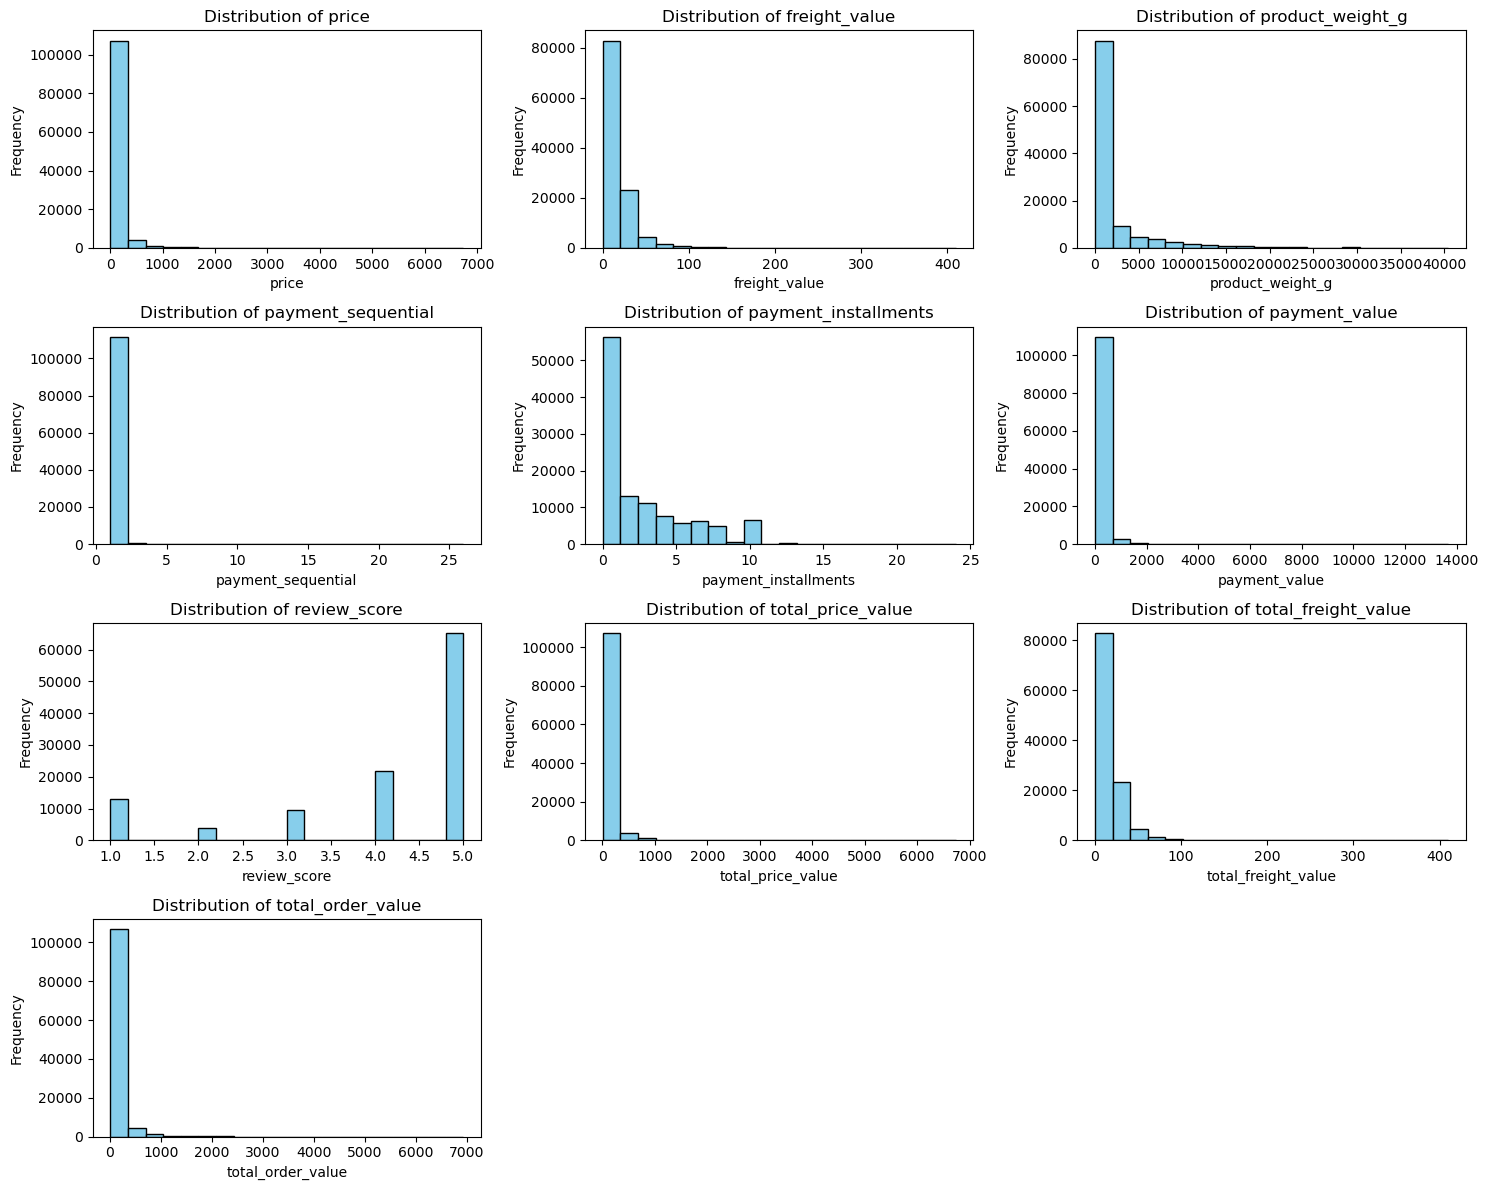

In [151]:
# Mengimpor modul math untuk menggunakan fungsi matematika, seperti pembulatan ke atas (ceil)
import math  

# Pilih kolom numerik dan buang yang terkait waktu
numerical_cols = df.select_dtypes(include=np.number).columns
excluded_cols = ['year', 'month', 'day_of_week', 'hour']
numerical_cols = [col for col in numerical_cols if col not in excluded_cols]

# Hitung jumlah baris dan kolom grid
num_cols = 3
num_rows = math.ceil(len(numerical_cols) / num_cols)

# Buat subplot grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))
axes = axes.flatten()

# Loop untuk buat histogram
for i, col in enumerate(numerical_cols):
    axes[i].hist(df[col].dropna(), bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Distribution of {col}', fontsize=12)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Sembunyikan subplot kosong (jika ada)
for i in range(len(numerical_cols), len(axes)):
    axes[i].set_visible(False)

# Atur layout dan tampilkan
plt.tight_layout()
plt.show()

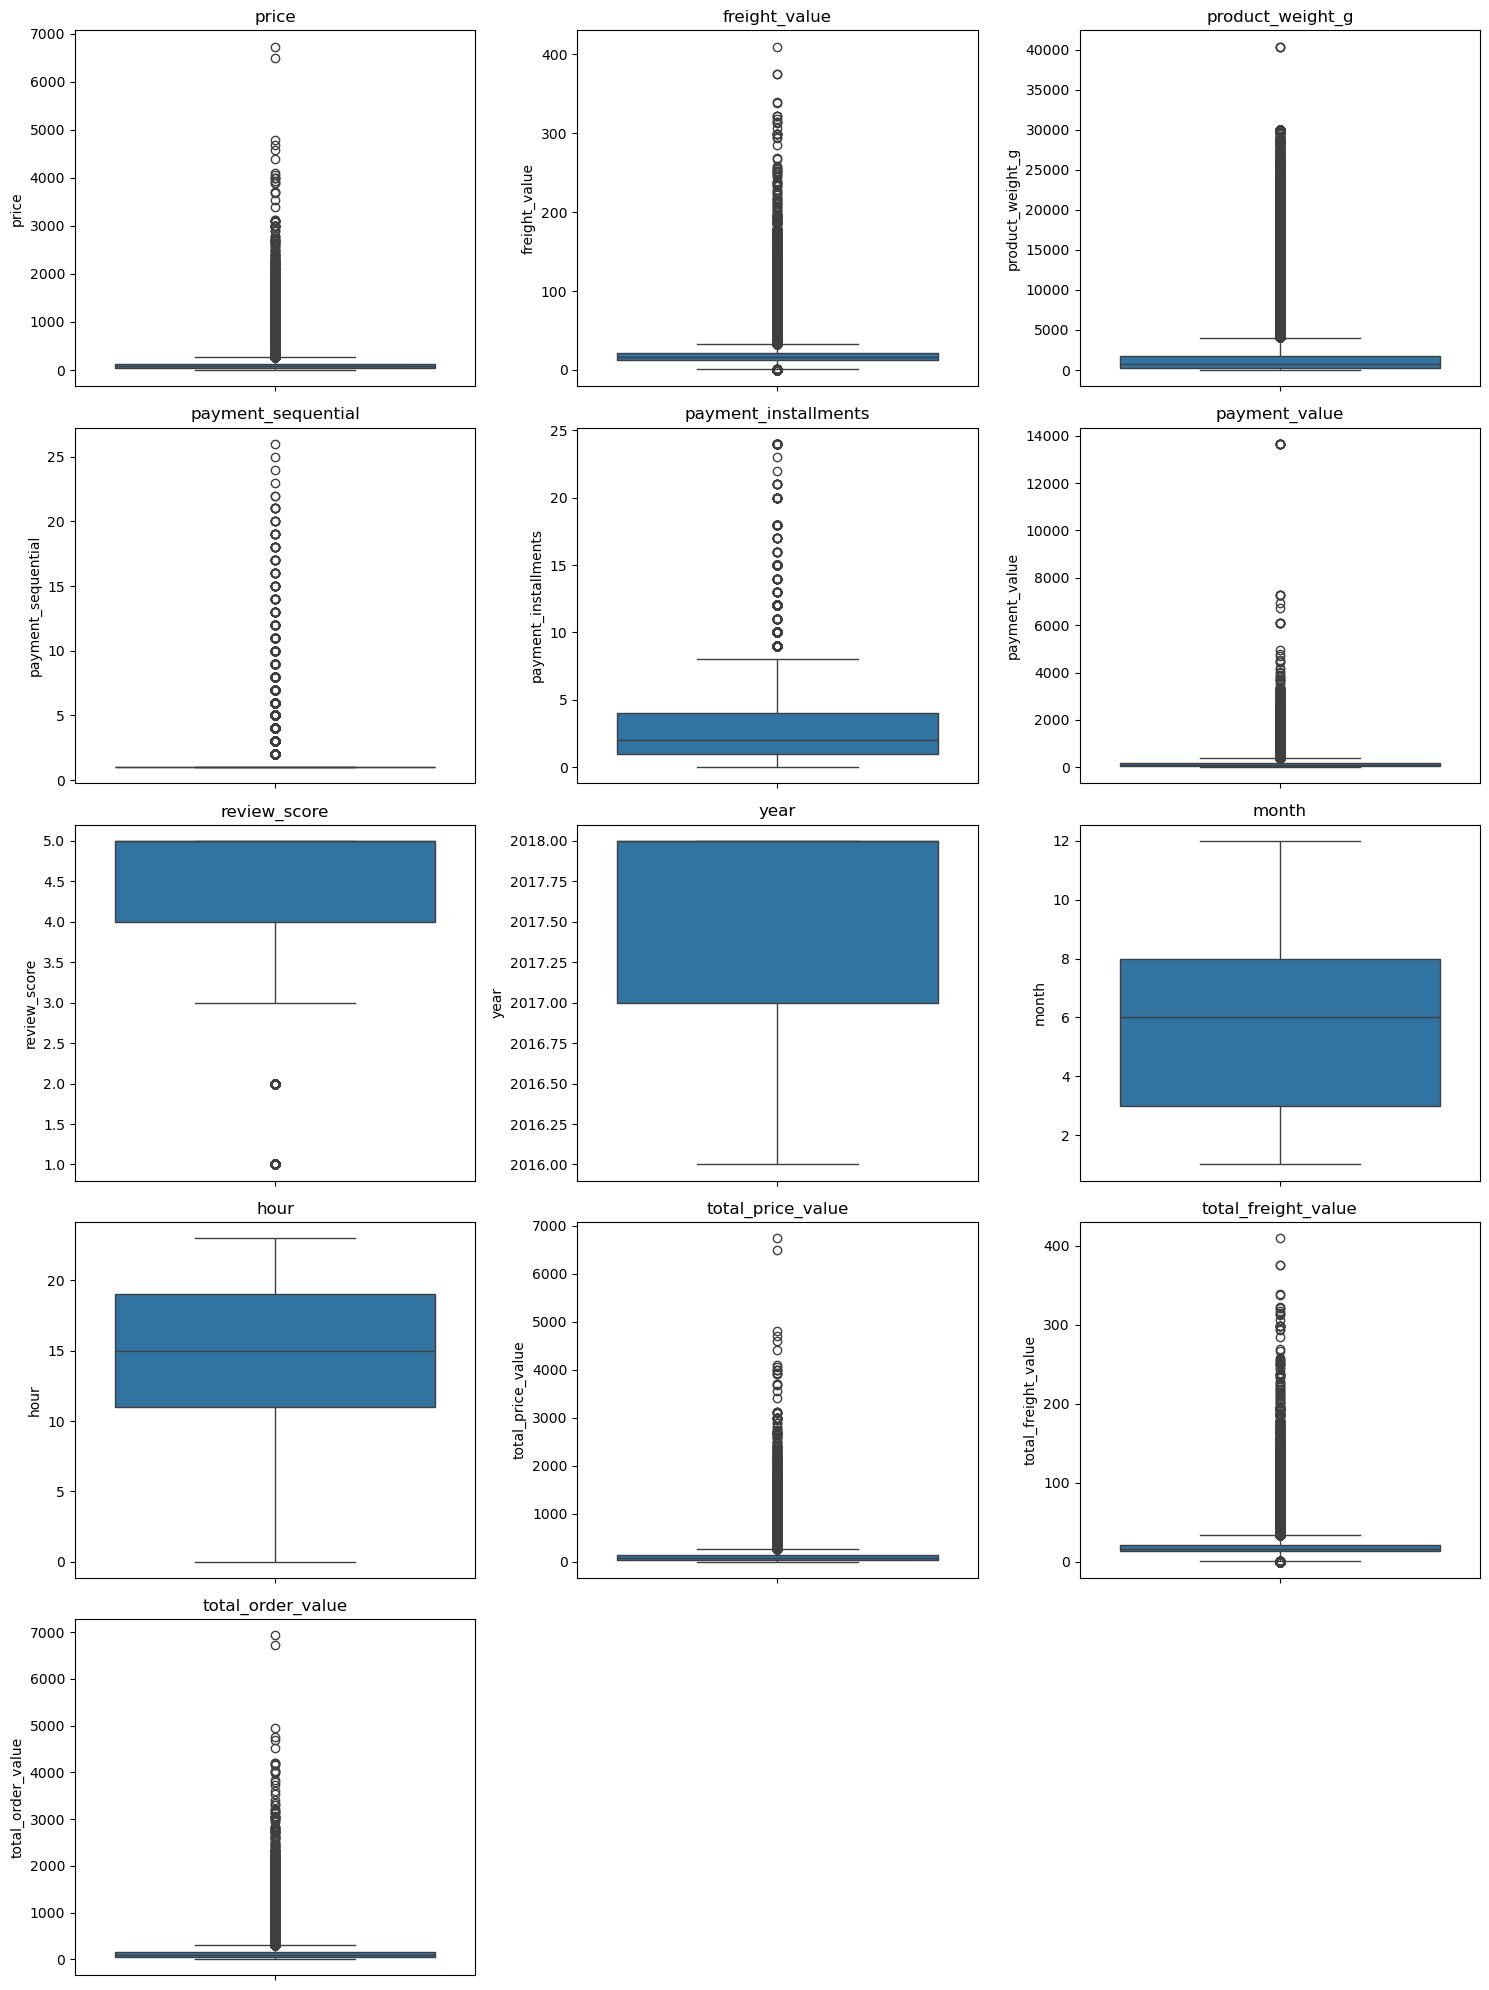

In [152]:
# Mengambil kolom-kolom bertipe numerik dari DataFrame
numerical_cols = df.select_dtypes(include=np.number).columns

# Menentukan jumlah baris dan kolom untuk grid visualisasi
num_cols_grid = 3  # Jumlah kolom dalam grid
num_rows = math.ceil(len(numerical_cols) / num_cols_grid)  # Menghitung jumlah baris yang dibutuhkan dengan pembulatan ke atas

# Membuat figure dan axes untuk grid subplot
fig, axes = plt.subplots(num_rows, num_cols_grid, figsize=(15, 4 * num_rows))

# Mengubah array axes menjadi satu dimensi untuk mempermudah iterasi
axes = axes.flatten()

# Melakukan iterasi pada setiap kolom numerik untuk membuat box plot
for i, col in enumerate(numerical_cols):
    sns.boxplot(y=df[col], ax=axes[i])  # Membuat box plot pada subplot saat ini
    axes[i].set_title(col)  # Menetapkan judul pada subplot
    axes[i].set_ylabel(col)  # Menetapkan label sumbu y

# Menyembunyikan subplot yang tidak digunakan
for i in range(len(numerical_cols), len(axes)):
    axes[i].set_visible(False)

# Menyesuaikan tata letak agar tidak saling bertabrakan dan menampilkan plot
plt.tight_layout()
plt.show()

“Visualisasi ini menunjukkan distribusi beberapa variabel utama dalam dataset, seperti harga produk, ongkos kirim, berat produk, nilai pembayaran, dan lain-lain. Mayoritas harga produk dan ongkir berada di kisaran rendah, yang menandakan dominasi produk dengan nilai transaksi kecil. Sebagian besar pembayaran dilakukan dalam satu kali cicilan, terlihat dari distribusi ‘payment_installments’ yang sangat tinggi di angka satu. Distribusi ini membantu kita memahami karakteristik umum transaksi dan dapat digunakan untuk menyusun strategi harga, promosi, serta opsi pembayaran yang lebih sesuai dengan perilaku customer.”

# 6. Customer Demographic
1. Change the name of the state and city columns to address static and address city then do a grouping to calculate the total  unique customer id based on the state address and it’s visualization

state → address_static

city → address_city

2. Create a grouping to calculate the total unique customer id based on the address city and its visualization
3. Make a table regarding the total orders for each customer, then create a column that describes the frequency of orders for each customer (assuming = if below equals 5 it is called a little, otherwise it is a lot)
4. Create a table that lists the first and last purchase dates for each customer, then combine the first purchase, last purchase, and total order tables to generate the difference total order between the last purchase date and the first purchase date
5. What are conclusions from your exploratory?

1. Change the name of the state and city columns to address static and address city then do a grouping to calculate the total unique customer id based on the state address and it’s visualization

state → address_static

city → address_city

In [153]:
# Mengganti nama kolom state dan city
df.rename(columns={'customer_state': 'address_static', 'customer_city': 'address_city'}, inplace=True)

In [154]:
df['address_city'].unique()

array(['sao paulo', 'barreiras', 'vianopolis', ..., 'messias targino',
       'campo do tenente', 'nova vicosa'], dtype=object)

In [155]:
# Menghitung jumlah unique customer_id berdasarkan address_static
customer_per_state = df.groupby('address_static')['customer_unique_id'].nunique().reset_index()
customer_per_state.rename(columns={'customer_unique_id': 'total_unique_customers'}, inplace=True)

In [156]:
# Melihat hasil
customer_per_state.head()

,address_static,total_unique_customers
0,AC,74
1,AL,380
2,AM,139
3,AP,65
4,BA,3093


In [157]:
# Melihat banyykny customer per provinsi / state / static
customer_per_state.groupby('address_static')['total_unique_customers'].sum().sort_values(ascending=False)

address_static
SP    38414
RJ    11618
MG    10777
RS     5071
PR     4682
SC     3370
BA     3093
DF     1980
ES     1889
GO     1837
PE     1520
CE     1238
PA      893
MT      839
MA      688
MS      670
PB      491
RN      455
PI      453
AL      380
SE      326
TO      263
RO      227
AM      139
AC       74
AP       65
RR       38
Name: total_unique_customers, dtype: int64

C:\Users\W10\AppData\Local\Temp\ipykernel_1092\1795988793.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='address_static', y='total_unique_customers',


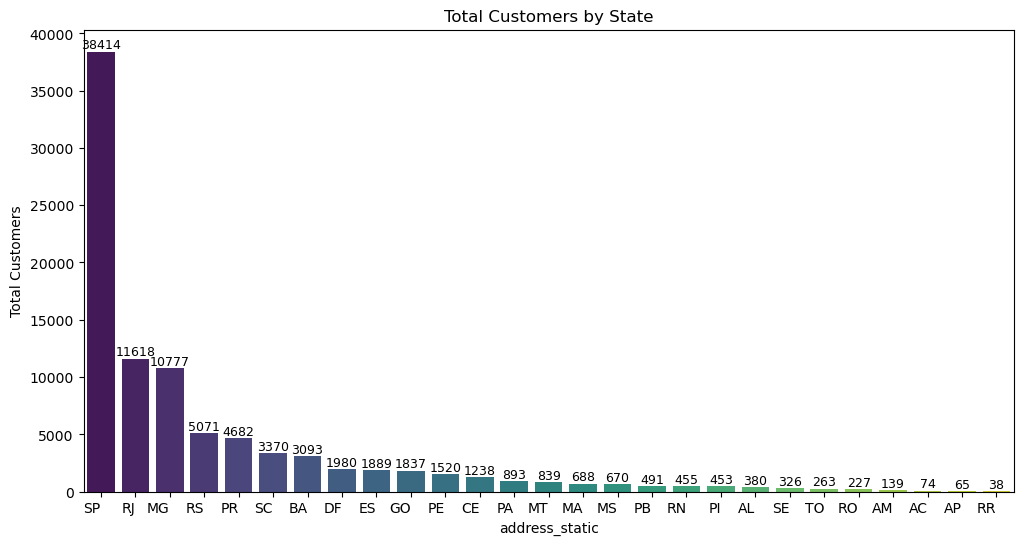

In [158]:
# Buat Visualisasi
# Urutkan data berdasarkan 'total_unique_customers' dari terbesar ke terkecil
customer_per_state = customer_per_state.sort_values(by='total_unique_customers', ascending=False)

# Buat figure dengan ukuran 12x6 inci
plt.figure(figsize=(12,6))

# Gunakan warna yang sesuai dari palet 'viridis'
ax = sns.barplot(x='address_static', y='total_unique_customers', 
                 data=customer_per_state, 
                 palette=sns.color_palette("viridis", n_colors=len(customer_per_state)))
# Tambahkan angka di atas setiap batang dengan lebih rapi
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', fontsize=9, color='black', label_type='edge')
# Rotasi label sumbu-x agar lebih mudah dibaca
plt.xticks(rotation=0, ha='right')
# Beri label pada sumbu-x
plt.xlabel("address_static")
# Beri label pada sumbu-y
plt.ylabel("Total Customers")
# Beri judul pada grafik
plt.title("Total Customers by State")
# Tampilkan plot
plt.show()

2. Create a grouping to calculate the total unique customer id based on the address city and its visualization


In [159]:
# Menghitung jumlah unique customer_id berdasarkan address_city
customer_per_city = df.groupby('address_city')['customer_unique_id'].nunique().reset_index()
customer_per_city.rename(columns={'customer_unique_id': 'total_unique_customers'}, inplace=True)

In [160]:
# Melihat hasil
customer_per_city.head()

,address_city,total_unique_customers
0,abadia dos dourados,3
1,abadiania,1
2,abaete,10
3,abaetetuba,11
4,abaiara,2


In [161]:
# Melihat banyykny customer per kota / city
customer_per_city.groupby('address_city')['total_unique_customers'].sum().sort_values(ascending=False).head(10)

address_city
sao paulo                14214
rio de janeiro            6197
belo horizonte            2546
brasilia                  1975
curitiba                  1412
campinas                  1339
porto alegre              1266
salvador                  1121
guarulhos                 1086
sao bernardo do campo      864
Name: total_unique_customers, dtype: int64

C:\Users\W10\AppData\Local\Temp\ipykernel_1092\3020751944.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='total_unique_customers', y='address_city', data=top_cities, palette='Blues_r')


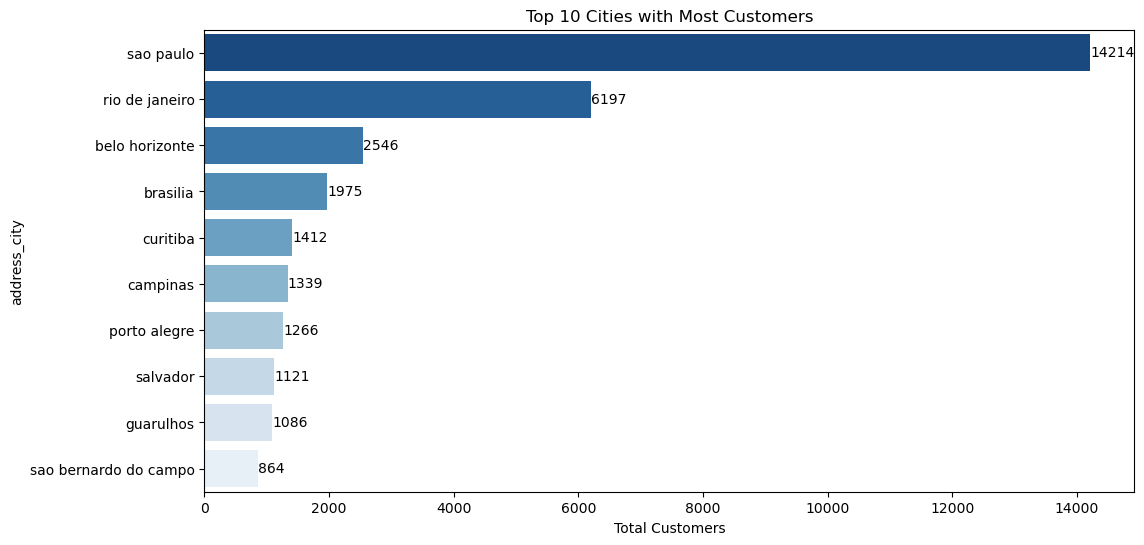

In [162]:
# Buat Visualisasi
# Pilih 10 kota dengan jumlah pelanggan unik terbanyak
top_cities = customer_per_city.sort_values(by='total_unique_customers', ascending=False).head(10)

# Buat figure dengan ukuran 12x6 inci
plt.figure(figsize=(12,6))
# Buat barplot horizontal
ax = sns.barplot(x='total_unique_customers', y='address_city', data=top_cities, palette='Blues_r')
# Tambahkan angka di setiap batang
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', fontsize=10, color='black', label_type='edge')
# Beri label pada sumbu-x dan sumbu-y
plt.xlabel("Total Customers")
plt.ylabel("address_city")
plt.title("Top 10 Cities with Most Customers")
plt.show()

3. Make a table regarding the total orders for each customer, then create a column that describes the frequency of orders for each customer (assuming = if below equals 5 it is called a little, otherwise it is a lot)

In [163]:
# Menghitung total order per customer
total_orders_per_customer = df.groupby('customer_unique_id')['order_id'].count().reset_index()
total_orders_per_customer.rename(columns={'order_id': 'total_orders'}, inplace=True)

# Menambahkan kolom frekuensi order
total_orders_per_customer['order_frequency'] = total_orders_per_customer['total_orders'].apply(lambda x: 'a little' if x < 5 else 'a lot')

In [164]:
# Melihat hasil
total_orders_per_customer

,customer_unique_id,total_orders,order_frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1,a little
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,a little
2,0000f46a3911fa3c0805444483337064,1,a little
3,0000f6ccb0745a6a4b88665a16c9f078,1,a little
4,0004aac84e0df4da2b147fca70cf8255,1,a little
...,...,...,...
91448,fffcf5a5ff07b0908bd4e2dbc735a684,2,a little
91449,fffea47cd6d3cc0a88bd621562a9d061,1,a little
91450,ffff371b4d645b6ecea244b27531430a,1,a little
91451,ffff5962728ec6157033ef9805bacc48,1,a little


In [165]:
total_orders_per_customer['order_frequency'].value_counts()

order_frequency
a little    90602
a lot         851
Name: count, dtype: int64

C:\Users\W10\AppData\Local\Temp\ipykernel_1092\4056538926.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=order_freq_counts.index, y=order_freq_counts.values, palette=['#1f77b4', '#4f92c3'])


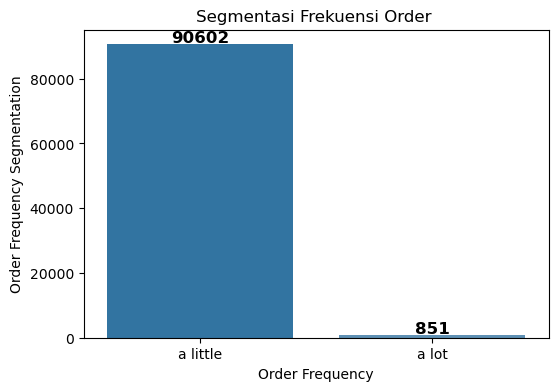

In [166]:
# Hitung jumlah pelanggan berdasarkan kategori order_frequency
order_freq_counts = total_orders_per_customer['order_frequency'].value_counts()

# Membuat figure
plt.figure(figsize=(6, 4))

# Membuat bar chart dengan warna biru
sns.barplot(x=order_freq_counts.index, y=order_freq_counts.values, palette=['#1f77b4', '#4f92c3'])

# Menambahkan label di atas setiap bar
for i, v in enumerate(order_freq_counts.values):
    plt.text(i, v + 500, str(v), ha='center', fontsize=12, fontweight='bold', color='black')

# Menambahkan label sumbu dan judul
plt.xlabel("Order Frequency")
plt.ylabel("Order Frequency Segmentation")
plt.title("Segmentasi Frekuensi Order ")
plt.show()

- Sebagian besar customer termasuk dalam segmen “little”. Jumlah customer pada segmen “lot” jauh lebih sedikit.

                       mean         std  median   min      max
order_frequency                                               
a little         141.419490  190.252647   92.97  7.28  6929.31
a lot            111.381521  141.106295   75.07  6.08  2511.75


C:\Users\W10\AppData\Local\Temp\ipykernel_1092\255101578.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='order_frequency', y='total_order_value', data=total_orders_per_customer_merged, palette='Set1')


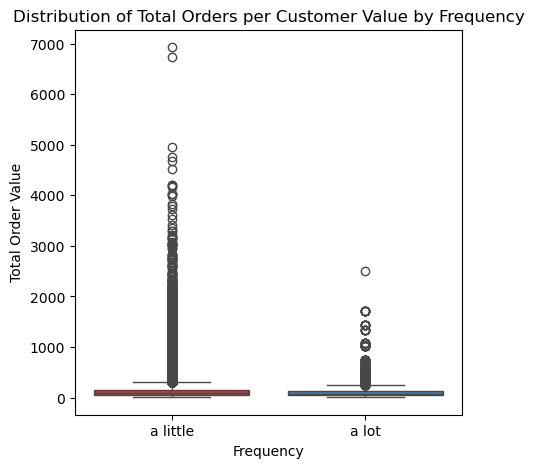

In [167]:
# Gabungkan total_orders_per_customer dengan dataframe
total_orders_per_customer_merged = pd.merge(total_orders_per_customer, df[['customer_unique_id', 'total_order_value']], on='customer_unique_id', how='left')

# Grouping dan Hitung Statistik
grouped_data = total_orders_per_customer_merged.groupby('order_frequency')['total_order_value'].agg(['mean', 'std', 'median', 'min', 'max'])
print(grouped_data)
# Membuat box plot
plt.figure(figsize=(5, 5))
sns.boxplot(x='order_frequency', y='total_order_value', data=total_orders_per_customer_merged, palette='Set1')
plt.title('Distribution of Total Orders per Customer Value by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Total Order Value')
plt.show()

- Terliha jelas bahwa kelompok "little" memiliki median nilai order yang lebih tinggi dan variabilitas yang lebih besar dibandingkan kelompok “lot".
- Selain itu, terlihat beberapa outlier pada kedua kelompok, terutama pada kelompok "little" dengan nilai order yang sangat tinggi.

4. Create a table that lists the first and last purchase dates for each customer, then combine the first purchase, last purchase, and total order tables to generate the difference total order between the last purchase date and the first purchase date

In [168]:
# Menghitung first dan last purchase per customer
purchase_dates = df.groupby('customer_unique_id')['order_purchase_timestamp'].agg(['min', 'max']).reset_index()
purchase_dates.rename(columns={'min': 'first_purchase_date', 'max': 'last_purchase_date'}, inplace=True)

# Menggabungkan dengan total order per customer ke table
difference_day_order = total_orders_per_customer.merge(purchase_dates, on='customer_unique_id', how='left')

# Menambahkan kolom selisih hari antara pembelian pertama dan terakhir
difference_day_order['difference_day_order'] = (difference_day_order['last_purchase_date'] - difference_day_order['first_purchase_date']).dt.days

In [169]:
# Melihat hasil
difference_day_order

,customer_unique_id,total_orders,order_frequency,first_purchase_date,last_purchase_date,difference_day_order
0,0000366f3b9a7992bf8c76cfdf3221e2,1,a little,2018-05-10 10:56:27,2018-05-10 10:56:27,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,a little,2018-05-07 11:11:27,2018-05-07 11:11:27,0
2,0000f46a3911fa3c0805444483337064,1,a little,2017-03-10 21:05:03,2017-03-10 21:05:03,0
3,0000f6ccb0745a6a4b88665a16c9f078,1,a little,2017-10-12 20:29:41,2017-10-12 20:29:41,0
4,0004aac84e0df4da2b147fca70cf8255,1,a little,2017-11-14 19:45:42,2017-11-14 19:45:42,0
...,...,...,...,...,...,...
91448,fffcf5a5ff07b0908bd4e2dbc735a684,2,a little,2017-06-08 21:00:36,2017-06-08 21:00:36,0
91449,fffea47cd6d3cc0a88bd621562a9d061,1,a little,2017-12-10 20:07:56,2017-12-10 20:07:56,0
91450,ffff371b4d645b6ecea244b27531430a,1,a little,2017-02-07 15:49:16,2017-02-07 15:49:16,0
91451,ffff5962728ec6157033ef9805bacc48,1,a little,2018-05-02 15:17:41,2018-05-02 15:17:41,0


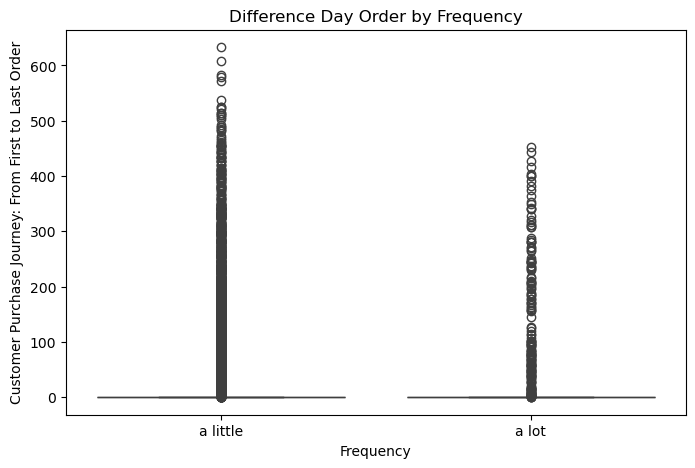

In [170]:
# Visualisasi hubungan antara difference_day_order dan order_frequency
plt.figure(figsize=(8, 5))
sns.boxplot(x='order_frequency', y='difference_day_order', data=difference_day_order)
plt.title('Difference Day Order by Frequency')
plt.xlabel('Frequency')
plt.ylabel('Customer Purchase Journey: From First to Last Order')
plt.show()

- Customer dengan frekuensi order rendah ("a little"):

    - Sebagian besar hanya melakukan pembelian dalam rentang waktu yang sangat pendek (bahkan 0 hari alias cuma 1 kali beli).

    - Tapi ada banyak outlier, yaitu customer dengan frekuensi rendah tapi jarak antar pembelian sangat panjang (bisa lebih dari 600 hari).

    - Ini bisa menunjukkan customer yang hanya sesekali beli, tapi masih kembali dalam jangka waktu lama.

- Customer dengan frekuensi order tinggi ("a lot"):

    -Umumnya memiliki rentang pembelian yang lebih panjang (lihat posisi median dan IQR yang lebih tinggi).

    - Variasi durasi antar pembelian juga lebih stabil (jarang outlier), yang artinya mereka lebih konsisten berbelanja dalam jangka waktu lama.


6. What are conclusions from your exploratory?

#### Conclusions
1. Distribusi Customer Berdasarkan Wilayah
- Berdasarkan distribusi customer berdsarkan wilayah, di state Sao Paulo (SP) memiliki jumlah customer terbanyak yang menunjukkan jumlah yang signifikan. Jika dilihat berdasarkan kota, dominasi tetap terlihat pada kota Sao Paulo dan Rio de Janeiro, sementara kota-kota lainnya mencatat jumlah pelanggan yang lebih rendah.
- Ini menunjukkan bahwa area ini merupakan pasar utama dan perlu menjadi fokus strategi bisnis.
2. Segmentasi  Customer
- Kelompok "a lot" adalah pelanggan setia yang sering melakukan pembelian dalam jangka waktu panjang. Mereka merupakan aset penting bagi perusahaan dan perlu dijaga loyalitasnya dengan layanan dan program khusus.
- Kelompok "a little" adalah pelanggan yang jarang melakukan pembelian. Untuk mereka yang hanya membeli sekali, perlu ditingkatkan pengalaman pertama agar mau kembali. Sementara yang pernah membeli tapi lama tidak aktif bisa ditargetkan dengan promosi atau pengingat berkala agar kembali bertransaksi.


# STEP 7: Order Behaviour
1. Create a grouping table that calculates the average number of items ordered each based on total customers (customer_unique_id), then create a column that describes the frequency of orders for each customer (assuming = if below equals 5 it is called a little, otherwise it is a lot)
2. Create a grouping table that calculates average item weight and standard deviation of item weight
3. Create a grouping table that calculates the most frequent order times by month and day, and its time (morning, evening, or night)
4. Create a grouping table that calculates the average total order value per order and classifies the average order price for each customer with the assumption that prices above 2500 are called expensive, prices between 1000 - 2500 are called normal, prices below 1000 are called cheap
5. Create a grouping table that calculates the most popular payment methods and the preference of each customer's product category
6. What are the most ordered categories each year and how are the categories developing each year?


1. Create a grouping table that calculates the average number of items ordered each based on total customers (customer_unique_id), then create a column that describes the frequency of orders for each customer (assuming = if below equals 5 it is called a little, otherwise it is a lot)

In [171]:
# Menghitung jumlah rata-rata item yang dipesan per customer
avg_items_per_customer = df.groupby('customer_unique_id')['order_item_id'].count().reset_index()
avg_items_per_customer.rename(columns={'order_item_id': 'avg_items_ordered'}, inplace=True)

# Menambahkan kolom kategori frekuensi order
# .apply(lambda x: ...) digunakan untuk menerapkan fungsi ke setiap baris (atau elemen) dalam sebuah kolom di DataFrame
avg_items_per_customer['order_frequency'] = avg_items_per_customer['avg_items_ordered'].apply(lambda x: 'a little' if x < 5 else 'a lot')

In [172]:
# Melihat hasil
avg_items_per_customer

,customer_unique_id,avg_items_ordered,order_frequency
0,0000366f3b9a7992bf8c76cfdf3221e2,1,a little
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,a little
2,0000f46a3911fa3c0805444483337064,1,a little
3,0000f6ccb0745a6a4b88665a16c9f078,1,a little
4,0004aac84e0df4da2b147fca70cf8255,1,a little
...,...,...,...
91448,fffcf5a5ff07b0908bd4e2dbc735a684,2,a little
91449,fffea47cd6d3cc0a88bd621562a9d061,1,a little
91450,ffff371b4d645b6ecea244b27531430a,1,a little
91451,ffff5962728ec6157033ef9805bacc48,1,a little


In [173]:
avg_items_per_customer['order_frequency'].value_counts()

order_frequency
a little    90602
a lot         851
Name: count, dtype: int64

C:\Users\W10\AppData\Local\Temp\ipykernel_1092\3935997358.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=order_freq_counts.index, y=order_freq_counts.values, palette='viridis')


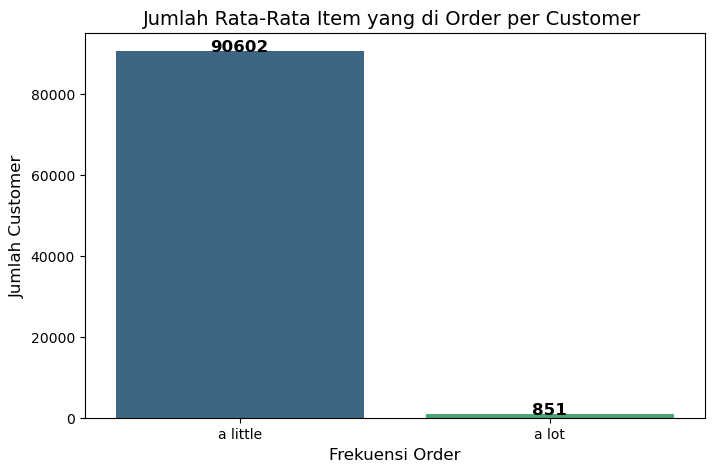

In [174]:
# Buat Visualisasi
# Menghitung jumlah customer dalam setiap kategori
order_freq_counts = avg_items_per_customer['order_frequency'].value_counts()

# Membuat bar chart
plt.figure(figsize=(8, 5))
sns.barplot(x=order_freq_counts.index, y=order_freq_counts.values, palette='viridis')

# Menampilkan angka di atas setiap batang
for i, v in enumerate(order_freq_counts.values):
    plt.text(i, v + 5, str(v), ha='center', fontsize=12, fontweight='bold')

# Menambahkan judul dan label
plt.title('Jumlah Rata-Rata Item yang di Order per Customer ', fontsize=14)
plt.xlabel('Frekuensi Order', fontsize=12)
plt.ylabel('Jumlah Customer', fontsize=12)

# Menampilkan plot
plt.show()

Berdasarkan visualisasi tersebut, terlihat bahwa sebagian besar customer melakukan pembelian secara tidak rutin. Sebanyak 90.602 customer termasuk dalam kategori "a little", yaitu customer yang jarang berbelanja. Sementara itu, hanya 851 customer yang tergolong sebagai customer frekuensi dalam kategori "a lot"

2. Create a grouping table that calculates average item weight and standard deviation of item weight

In [175]:
# Menghitung rata-rata dan standar deviasi berat barang
item_weight = df.groupby('product_category_name_english')['product_weight_g'].agg({'mean', 'std'})
item_weight.sort_values(by='mean', ascending=False)

,mean,std
product_category_name_english,,
office_furniture,11241.560069,4795.625249
furniture_bedroom,10319.957983,5177.439018
home_appliances_2,9875.324427,7135.254917
kitchen_dining_laundry_garden_furniture,8777.252595,8158.100428
furniture_mattress_and_upholstery,8388.750000,10823.369111
...,...,...
fashion_sport,340.000000,349.235619
tablets_printing_image,292.411765,64.339186
fashion_childrens_clothes,285.714286,203.540098


C:\Users\W10\AppData\Local\Temp\ipykernel_1092\1037167436.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


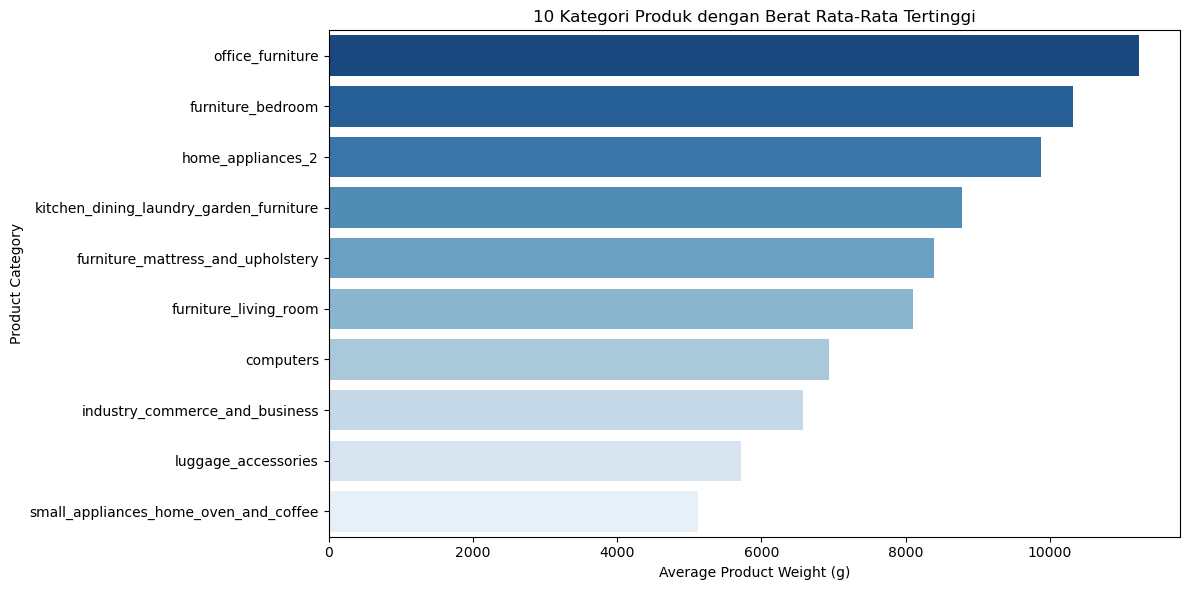

In [176]:
# Menghitung rata-rata dan standar deviasi berat barang
item_weight = df.groupby('product_category_name_english')['product_weight_g'].agg(['mean', 'std'])

# Mengambil 10 kategori teratas berdasarkan rata-rata berat
top10_weight = item_weight.sort_values(by='mean', ascending=False).head(10).reset_index()

# Plot barplot horizontal
plt.figure(figsize=(12,6))
ax = sns.barplot(
    x='mean',
    y='product_category_name_english',
    data=top10_weight,
    palette='Blues_r'
)
plt.xlabel('Average Product Weight (g)')
plt.ylabel('Product Category')
plt.title('10 Kategori Produk dengan Berat Rata-Rata Tertinggi')
plt.tight_layout()
plt.show()


C:\Users\W10\AppData\Local\Temp\ipykernel_1092\1751645501.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


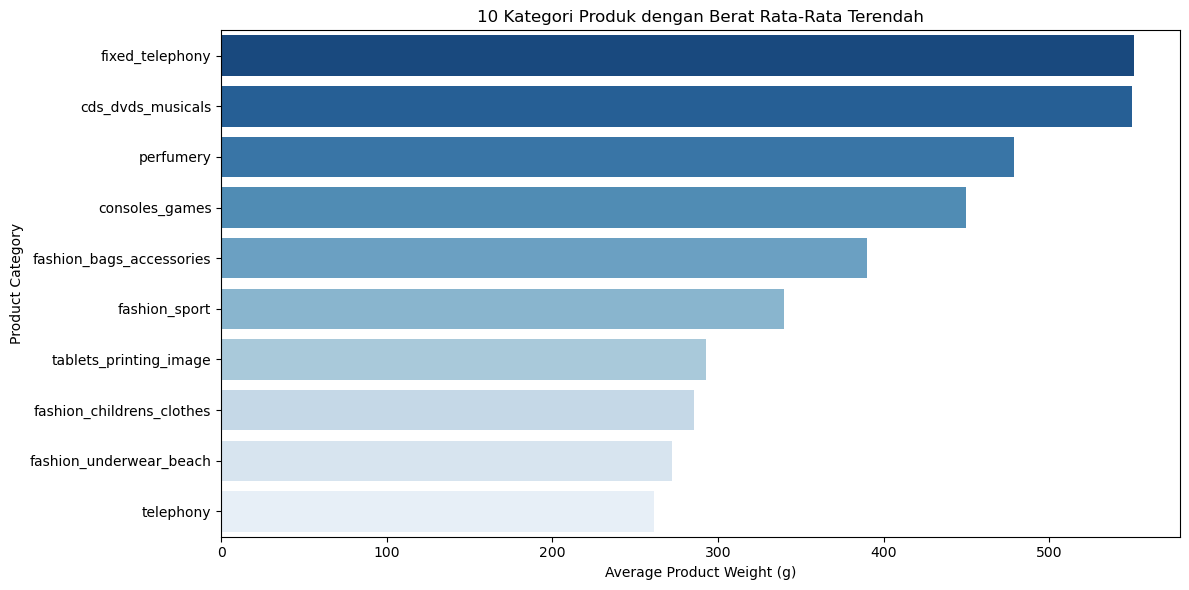

In [177]:
# Menghitung rata-rata dan standar deviasi berat barang
item_weight = df.groupby('product_category_name_english')['product_weight_g'].agg(['mean', 'std'])

# Mengambil 10 kategori terbawah berdasarkan rata-rata berat
top10_weight = item_weight.sort_values(by='mean', ascending=False).tail(10).reset_index()

# Plot barplot horizontal
plt.figure(figsize=(12,6))
ax = sns.barplot(
    x='mean',
    y='product_category_name_english',
    data=top10_weight,
    palette='Blues_r'
)
plt.xlabel('Average Product Weight (g)')
plt.ylabel('Product Category')
plt.title('10 Kategori Produk dengan Berat Rata-Rata Terendah')
plt.tight_layout()
plt.show()


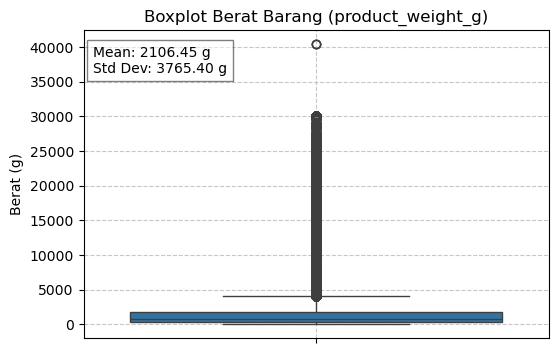

In [178]:
# Menghitung rata-rata dan standar deviasi berat barang
item_weight = df['product_weight_g'].agg(['mean', 'std'])

# Menyimpan nilai mean dan std ke dalam variabel
mean_weight = item_weight['mean']
std_weight = item_weight['std']

# Membuat boxplot
plt.figure(figsize=(6, 4))
sns.boxplot(y=df['product_weight_g'])
plt.title('Boxplot Berat Barang (product_weight_g)')
plt.ylabel('Berat (g)')
plt.grid(True, linestyle='--', alpha=0.7)

# Menampilkan mean dan standar deviasi
txt = f"Mean: {mean_weight:.2f} g\nStd Dev: {std_weight:.2f} g"
plt.text(0.02, 0.95, txt, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

# Menampilkan plot
plt.show()

Analisis Berat Produk pada Dataset
1. Top 10 Kategori Produk Paling Berat
    - Produk dengan rata-rata berat tertinggi didominasi oleh furniture dan home appliances.

    - Kategori paling berat: office_furniture, furniture_bedroom, dan home_appliances_2.

    - Produk-produk ini cenderung besar dan berat, berpengaruh pada biaya logistik yang lebih tinggi.

2. Top 10 Kategori Produk Paling Ringan
    - Produk dengan berat rata-rata paling ringan berasal dari kategori kecil dan ringan seperti cds_dvds_musicals, perfumery, dan fashion_underwear_beach.

    - Ringan dan mudah dikemas, menguntungkan untuk pengiriman cepat dan biaya logistik rendah.

3. Distribusi Berat Produk (Boxplot)
    - Rata-rata berat produk: 2.106 gram.

    - Standar deviasi: 3.765 gram → menunjukkan variasi berat yang sangat besar antar produk.

    - Terlihat bahwa mayoritas produk beratnya di bawah rata-rata, tetapi terdapat beberapa outlier (produk sangat berat) yang menyebabkan distribusi positively skewed (condong ke kanan).


4. Insight dan Implikasi Bisnis:
    - Segmentasi Pengiriman: Produk berat seperti furnitur memerlukan strategi pengiriman khusus, mungkin dengan mitra logistik berat. Sebaliknya, produk ringan cocok untuk layanan ekspres.

    - Optimasi Biaya: Menyadari variasi berat yang besar bisa membantu dalam pengelolaan gudang dan penetapan ongkos kirim yang lebih akurat.

    - Bundle Strategy: Kategori ringan bisa dibundling untuk meningkatkan nilai transaksi, tanpa menambah beban logistik secara signifikan.

3. Create a grouping table that calculates the most frequent order times by month and day, and its time (morning, evening, or night)

In [180]:
# Definisikan fungsi untuk mengkategorikan waktu berdasarkan jam
def categorize_time(hour):
    """
    Mengkategorikan waktu berdasarkan jam.
    - Morning: 06:00 - 11:59
    - Evening: 12:00 - 17:59
    - Night: 18:00 - 05:59
    """
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'evening'
    else:
        return 'night'

# Terapkan fungsi untuk membuat kolom baru 'time_category'
df['time_category'] = df['hour'].apply(categorize_time)
# Kelompokkan data berdasarkan bulan, hari, dan kategori waktu, lalu hitung jumlah order
order_frequency = df.groupby(['month', 'day', 'time_category'])['order_id'].count().reset_index()
# Ganti nama kolom hasil agregasi agar lebih informatif
order_frequency.rename(columns={'order_id': 'order_count'}, inplace=True)
# Urutkan berdasarkan bulan, hari, dan jumlah order secara menurun (agar bisa ambil yang paling sering)
order_frequency = order_frequency.sort_values(by=['month', 'day', 'order_count'], ascending=[True, True, False])
# Ambil hanya kategori waktu dengan order terbanyak untuk setiap kombinasi bulan dan hari
most_frequent_order_times = order_frequency.groupby(['month', 'day']).first().reset_index()

In [223]:
# Tampilkan hasil akhir
most_frequent_order_times.head()

,month,day,time_category,order_count
0,1,Friday,evening,496
1,1,Monday,night,631
2,1,Saturday,night,406
3,1,Sunday,night,453
4,1,Thursday,evening,537


In [225]:
# Urutkan berdasarkan order_count dari terbesar ke terkecil
most_frequent_order_times_sorted = most_frequent_order_times.sort_values(by='order_count', ascending=False)
most_frequent_order_times_sorted = most_frequent_order_times.sort_values(by='order_count', ascending=False).reset_index(drop=True)
# Tampilkan hasil 10 teratas
most_frequent_order_times_sorted.head(10)

,month,day,time_category,order_count
0,5,Tuesday,night,925
1,11,Friday,night,883
2,5,Wednesday,night,876
3,8,Wednesday,evening,864
4,7,Monday,night,860
5,8,Thursday,evening,836
6,8,Tuesday,night,823
7,5,Monday,evening,820
8,7,Tuesday,evening,798
9,4,Monday,night,785


C:\Users\W10\AppData\Local\Temp\ipykernel_1092\1153836649.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


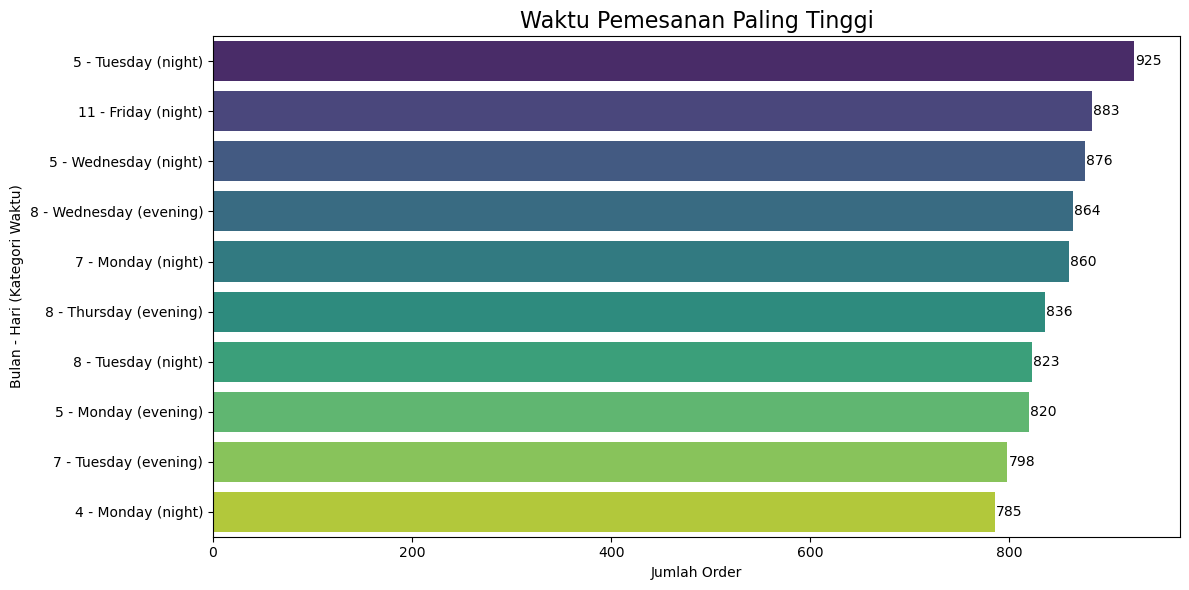

In [233]:
# Buat kolom gabungan label untuk sumbu Y
most_frequent_order_times_sorted['label'] = (
    most_frequent_order_times_sorted['month'].astype(str) + ' - ' +
    most_frequent_order_times_sorted['day'] + ' (' +
    most_frequent_order_times_sorted['time_category'] + ')'
)

# Ambil 10 teratas
top_10 = most_frequent_order_times_sorted.head(10)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_10, 
    y='label', 
    x='order_count', 
    palette='viridis'
)

plt.title('Waktu Pemesanan Paling Tinggi', fontsize=16)
plt.xlabel('Jumlah Order')
plt.ylabel('Bulan - Hari (Kategori Waktu)')

# Tambahkan angka di bar
for index, row in top_10.iterrows():
    plt.text(row['order_count'] + 1, index, row['order_count'], va='center')

plt.tight_layout()
plt.show()

- Top 3 dari waktu pemesanan paling sering order, pada bulan mei dan waktu malam hari

C:\Users\W10\AppData\Local\Temp\ipykernel_1092\609607296.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='month', y='order_count', data=order_by_month, ax=axes[0], palette='Blues')
C:\Users\W10\AppData\Local\Temp\ipykernel_1092\609607296.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day', y='order_count', data=order_by_day, ax=axes[1], palette='Greens')
C:\Users\W10\AppData\Local\Temp\ipykernel_1092\609607296.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='time_category', y='order_count', data=order_by_time, ax=axes[

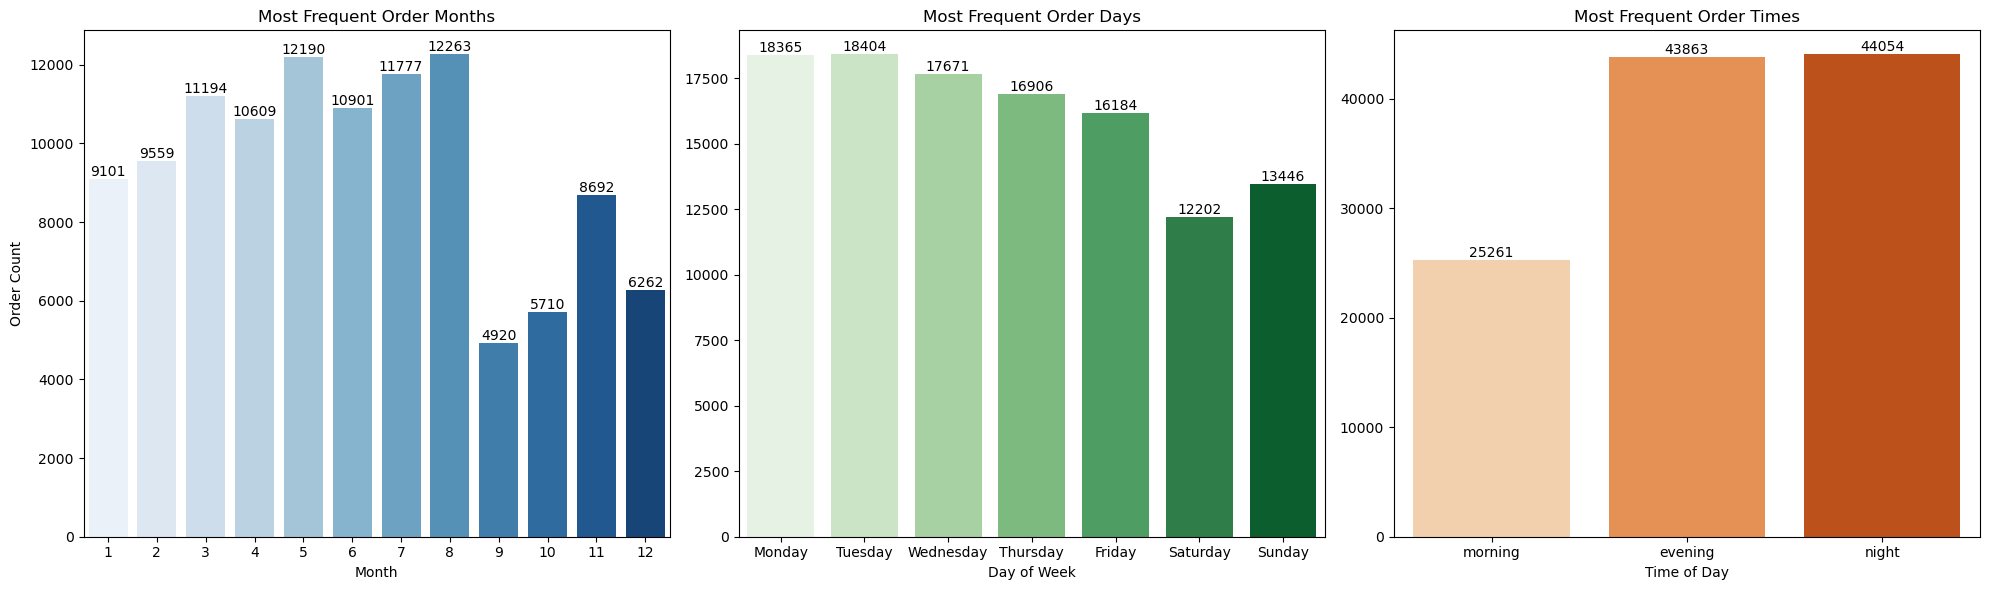

In [236]:
# Hitung jumlah order per bulan
order_by_month = df.groupby('month')['order_id'].count().reset_index(name='order_count')
# Hitung jumlah order per hari
order_by_day = df.groupby('day')['order_id'].count().reset_index(name='order_count')
# Hitung jumlah order per kategori waktu
order_by_time = df.groupby('time_category')['order_id'].count().reset_index(name='order_count')

# Urutkan hari
order_by_day['day'] = pd.Categorical(
    order_by_day['day'],
    categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    ordered=True
)
order_by_day.sort_values('day', inplace=True)

# Urutkan kategori waktu (kalau kamu ingin urutan tertentu)
time_order = ['morning', 'evening', 'night']
order_by_time['time_category'] = pd.Categorical(order_by_time['time_category'], categories=time_order, ordered=True)
order_by_time.sort_values('time_category', inplace=True)

# Buat figure dan subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Barplot per bulan
sns.barplot(x='month', y='order_count', data=order_by_month, ax=axes[0], palette='Blues')
axes[0].set_title('Most Frequent Order Months')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Order Count')
# Menampilkan label nilai di atas batang pada plot pertama
for p in axes[0].containers:
    axes[0].bar_label(p, fmt='%d', fontsize=10)
    
# Barplot per hari
sns.barplot(x='day', y='order_count', data=order_by_day, ax=axes[1], palette='Greens')
axes[1].set_title('Most Frequent Order Days')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('')
# Menampilkan label nilai di atas batang pada plot pertama
for p in axes[1].containers:
    axes[1].bar_label(p, fmt='%d', fontsize=10)

# Barplot per kategori waktu
sns.barplot(x='time_category', y='order_count', data=order_by_time, ax=axes[2], palette='Oranges')
axes[2].set_title('Most Frequent Order Times')
axes[2].set_xlabel('Time of Day')
axes[2].set_ylabel('')
# Menampilkan label nilai di atas batang pada plot pertama
for p in axes[2].containers:
    axes[2].bar_label(p, fmt='%d', fontsize=10)
    
# Tampilkan semua grafik
plt.tight_layout()
plt.show()

#### Kesimpulan Pola Pemesanan Berdasarkan Waktu Secara Global
- Bulan Paling Ramai (Most Frequent Order Months)

    - Pemesanan tertinggi terjadi pada bulan ke-8 (Agustus).

    - Aktivitas pesanan cenderung tinggi selama bulan 3–8, kemudian menurun drastis di bulan 9–12.


- Hari Paling Ramai (Most Frequent Order Days)

    - Hari Senin menjadi hari dengan jumlah pesanan terbanyak, diikuti oleh Selasa dan Rabu.

    - Pesanan menurun saat akhir pekan, terutama pada Sabtu dan Minggu .

- Waktu Paling Ramai dalam Sehari (Most Frequent Order Times)

    - Malam dan sore hari menjadi waktu paling aktif untuk melakukan pemesanan.

    - Aktivitas pesanan paling rendah terjadi pada pagi hari.


4. Create a grouping table that calculates the average total order value per order and classifies the average order price for each customer with the assumption that prices above 2500 are called expensive, prices between 1000 - 2500 are called normal, prices below 1000 are called cheap

In [183]:
# Menghitung total order value
df['total_order_value'] = df['price'] + df['freight_value']

# Menghitung rata-rata nilai order per customer
avg_order_value_per_customer = df.groupby('customer_unique_id')['total_order_value'].mean().reset_index()
avg_order_value_per_customer.rename(columns={'total_order_value': 'avg_order_value'}, inplace=True)

# Mengkategorikan harga order
def classify_order_price(value):
    if value > 2500:
        return 'Expensive'
    elif 1000 <= value <= 2500:
        return 'Normal'
    else:
        return 'Cheap'

avg_order_value_per_customer['price_classify'] = avg_order_value_per_customer['avg_order_value'].apply(classify_order_price)

In [184]:
# Melihat hasil
avg_order_value_per_customer.head()

,customer_unique_id,avg_order_value,price_classify
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,Cheap
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,Cheap
2,0000f46a3911fa3c0805444483337064,86.22,Cheap
3,0000f6ccb0745a6a4b88665a16c9f078,43.62,Cheap
4,0004aac84e0df4da2b147fca70cf8255,196.89,Cheap


In [185]:
avg_order_value_per_customer['price_classify'].value_counts()

price_classify
Cheap        90574
Normal         820
Expensive       59
Name: count, dtype: int64

C:\Users\W10\AppData\Local\Temp\ipykernel_1092\3981402222.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


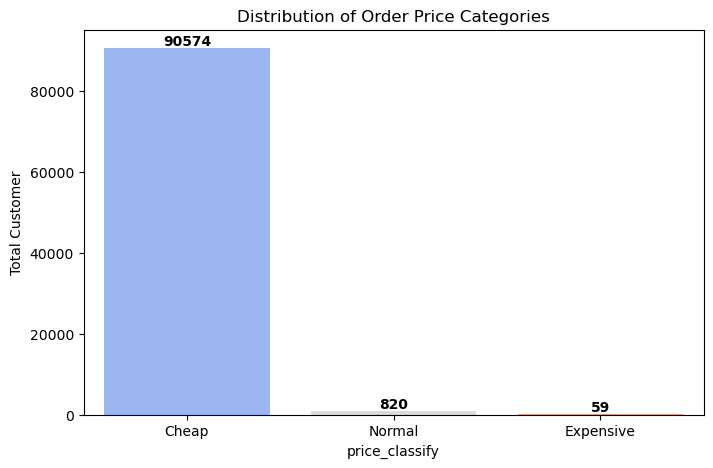

In [186]:
# Membuat ukuran plot
plt.figure(figsize=(8, 5))

# Membuat countplot dengan urutan kategori
ax = sns.countplot(
    x='price_classify', 
    data=avg_order_value_per_customer, 
    palette='coolwarm', 
    order=['Cheap', 'Normal', 'Expensive']
)

# Menambahkan angka di atas setiap batang
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), '.0f'),  # Menampilkan angka tanpa desimal
        (p.get_x() + p.get_width() / 2., p.get_height()),  # Posisi teks
        ha='center', va='bottom', fontsize=10, fontweight='bold', color='black'
    )

# Menambahkan judul dan label
plt.title('Distribution of Order Price Categories')
plt.xlabel('price_classify')
plt.ylabel('Total Customer')

# Menampilkan plot
plt.show()

Mayoritas customer cenderung membeli produk dengan harga murah, terlihat dari 90.574 pesanan yang termasuk dalam kategori "Cheap". Sementara itu, hanya 820 pesanan berada di kategori "Normal", dan sangat sedikit pelanggan yang membeli produk "Expensive", yaitu hanya 59 pesanan.

C:\Users\W10\AppData\Local\Temp\ipykernel_1092\159832967.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=order_counts.index, y=order_counts.values, palette='coolwarm', order=['Cheap', 'Normal', 'Expensive'], ax=axes[0])


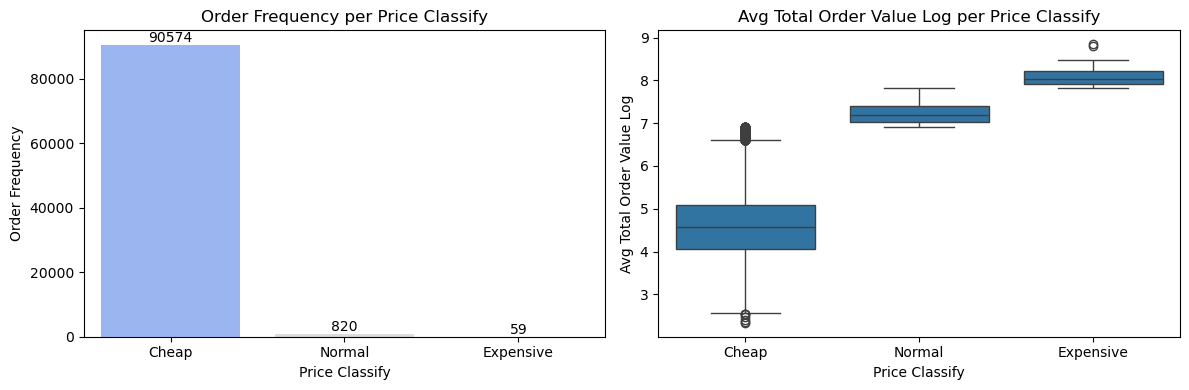

                       mean         std    median          min      max
price_classify                                                         
Cheap            132.271654  124.797070    95.220     9.341429   997.37
Expensive       3325.032627  874.499093  3042.360  2512.530000  6929.31
Normal          1420.627555  362.094795  1323.545  1002.710000  2467.33


In [187]:
# Membuat grafik
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # Sesuaikan figsize

# Menghitung jumlah pesanan per kategori price_classify
order_counts = avg_order_value_per_customer['price_classify'].value_counts()

# Barplot pertama (Order Frequency per Price Classify)
ax = sns.barplot(x=order_counts.index, y=order_counts.values, palette='coolwarm', order=['Cheap', 'Normal', 'Expensive'], ax=axes[0])
for container in ax.containers[0:]:
    ax.bar_label(container)
axes[0].set_title('Order Frequency per Price Classify')
axes[0].set_xlabel('Price Classify')
axes[0].set_ylabel('Order Frequency')

# Menambahkan kolom log transform untuk avg_order_value
avg_order_value_per_customer['avg_order_value_log'] = np.log1p(avg_order_value_per_customer['avg_order_value'])

# Boxplot kedua (Avg Total Order Value Log per Price Classify)
sns.boxplot(x='price_classify', y='avg_order_value_log', data=avg_order_value_per_customer, order=['Cheap', 'Normal', 'Expensive'], ax=axes[1])
axes[1].set_title('Avg Total Order Value Log per Price Classify')
axes[1].set_xlabel('Price Classify')
axes[1].set_ylabel('Avg Total Order Value Log')

plt.tight_layout()
plt.show()

# Grouping dan Hitung Statistik
grouped_data_order_price = avg_order_value_per_customer.groupby('price_classify')['avg_order_value'].agg(['mean', 'std', 'median', 'min', 'max'])
print(grouped_data_order_price)

- Kategori "cheap" cenderung memiliki frekuensi order tertinggi, diikuti oleh "normal", dan terakhir "expensive“.
- Namun kategori normal dan mahal memberikan nilai transaksi rata-rata yang lebih tinggi.

5. Create a grouping table that calculates the most popular payment methods and the preference of each customer's product category

In [188]:
# Menampilkan metode pembayaran paling populer
df['payment_type'].value_counts()

payment_type
credit_card    83519
boleto         22015
voucher         6022
debit_card      1622
Name: count, dtype: int64

- Dilihat dari total keseluruhan transaksi, metode pembayaran yang paling tinggi adalah credit_card

In [189]:
# Kelompokkan data berdasarkan customer dan jenis metode pembayaran,
# lalu hitung jumlah order untuk kombinasi tersebut sebagai preferensi pembayaran
payment_preference = df.groupby(['customer_unique_id', 'payment_type'])['order_id'].count().reset_index()

# Ganti nama kolom 'order_id' menjadi 'frequency' untuk merepresentasikan jumlah transaksi
payment_preference.rename(columns={'order_id': 'frequency'}, inplace=True)

# Untuk setiap customer, ambil metode pembayaran dengan frekuensi tertinggi (paling sering digunakan)
popular_payment = payment_preference.loc[
    payment_preference.groupby('customer_unique_id')['frequency'].idxmax()
]

# Tampilkan 10 sampel acak dari hasil metode pembayaran terpopuler per customer
display(popular_payment.sample(10))

# Hitung metode pembayaran yang paling umum digunakan di antara semua customer
mode_popular_payment = popular_payment['payment_type'].mode()[0]

# Hitung berapa banyak customer yang paling sering menggunakan metode 'credit_card'
count_popular_payment = popular_payment[popular_payment['payment_type'] == 'credit_card'].count()[0]

# Cetak hasil metode pembayaran terpopuler beserta jumlah customer yang menggunakannya
print(f"\nMetode pembayaran yang paling sering digunakan customer adalah {mode_popular_payment} sebanyak {count_popular_payment} kali")

,customer_unique_id,payment_type,frequency
70737,c0888c415e05dfbb9beaa9c8ac62371a,credit_card,1
60145,a3edd25ad970b09c9bbbad6eb77c3c80,credit_card,1
8840,17eb2dcf3b6c44be06f2212d1cb555cc,boleto,1
75022,cc617bfe83c254c559215bc9fa50b88c,credit_card,1
47572,817e4269707e78bf6a860b10968538bb,credit_card,1
22347,3cd8a4523dd9a286b3d3d6ab7d7f6f16,credit_card,1
33678,5b927be15533b8876fba5972cf878e74,boleto,1
3992,0ab20fb5f6b4eefe822ea405a4ec60c5,credit_card,1
10081,1b5a1fb128d2fb23ffc39090575c46ad,credit_card,1
66446,b4ef898844c5ae6970a6d0cda79cb367,credit_card,2



Metode pembayaran yang paling sering digunakan customer adalah credit_card sebanyak 70050 kali


C:\Users\W10\AppData\Local\Temp\ipykernel_1092\3306485393.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  count_popular_payment = popular_payment[popular_payment['payment_type'] == 'credit_card'].count()[0]


In [190]:
# Kelompokkan data berdasarkan customer_unique_id dan product_category
product_preference = df.groupby(['customer_unique_id', 'product_category_name_english'])['order_id'].count().reset_index()

# Ubah nama kolom order_id menjadi frequency
product_preference.rename(columns={'order_id': 'frequency'}, inplace=True)

# Melihat kategori produk terpopuler untuk setiap customer
popular_product = product_preference.loc[product_preference.groupby('customer_unique_id')['frequency'].idxmax()]

# Gabungkan kedua tabel dengan semua kolom dari most_popular_product
populer_payment_method_and_product = pd.merge(popular_payment, popular_product[['customer_unique_id', 'product_category_name_english']], on='customer_unique_id', how='left')
populer_payment_method_and_product.sort_values(by='frequency', ascending=False)

,customer_unique_id,payment_type,frequency,product_category_name_english
55223,9a736b248f67d166d2fbb006bcb877c3,voucher,75,bed_bath_table
39997,6fbc7cdadbb522125f4b27ae9dee4060,voucher,36,office_furniture
89260,f9ae226291893fda10af7965268fb7f6,voucher,32,garden_tools
31029,569aa12b73b5f7edeaa6f2a01603e381,voucher,25,bed_bath_table
71652,c8460e4251689ba205045f3ea17884a1,credit_card,24,telephony
...,...,...,...,...
32530,5aaf237a53b94f01b6043dd1ec7b0339,boleto,1,small_appliances
32529,5aaea40535337a39bb7b3a959b28b58e,credit_card,1,pet_shop
32528,5aada67971539e52689adbfd30b869da,credit_card,1,baby
32527,5aabf2f00c4169c998bd00b0c1eff66f,credit_card,1,electronics


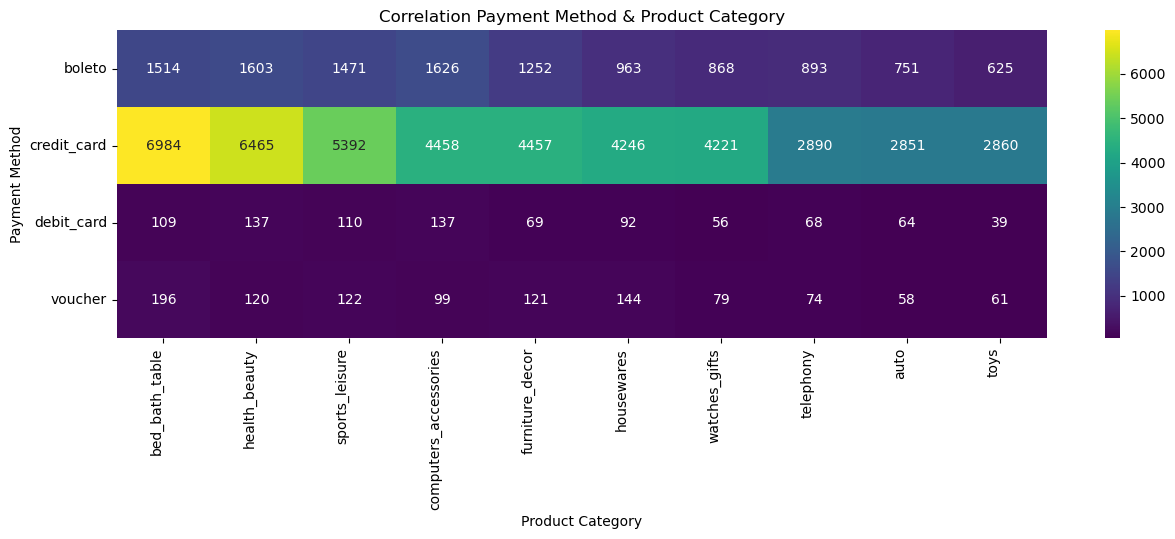

In [191]:
# Membuat crosstab untuk menghitung frekuensi kombinasi metode pembayaran dan kategori produk
payment_product_crosstab = pd.crosstab(populer_payment_method_and_product['payment_type'],
                                        populer_payment_method_and_product['product_category_name_english'])

# Mengambil 10 kategori produk terpopuler
top_10_categories = payment_product_crosstab.sum(axis=0).sort_values(ascending=False).head(10).index

# Memfilter crosstab untuk hanya menyertakan 10 kategori terpopuler
payment_product_crosstab_top10 = payment_product_crosstab[top_10_categories]

# Membuat heatmap
plt.figure(figsize=(15, 4))
sns.heatmap(payment_product_crosstab_top10, annot=True, cmap='viridis', fmt='d')  # Menambahkan anotasi dan format angka
plt.title('Correlation Payment Method & Product Category')
plt.xlabel('Product Category')
plt.ylabel('Payment Method')
plt.xticks(rotation=90, ha='right')  # Rotasi label sumbu x agar mudah dibaca
plt.yticks(rotation=0)  # Mengatur rotasi label sumbu y menjadi 0
plt.show()

- Visualisasi heatmap ini menunjukkan bahwa kartu kredit menjadi metode pembayaran yang paling dominan
- Kategori bed_bath_table adalah produk yang paling banyak dibeli
- Kemudian Boleto juga cukup populer pada beberapa kategori seperti computers_accessories. Sementara itu, kartu debit dan voucher menunjukkan jumlah transaksi yang relatif lebih rendah.
- Insight ini dapat membantu kita dalam mengoptimalkan strategi pembayaran dan menyesuaikan penawaran berdasarkan preferensi konsumen di setiap kategori produk."

6. What are the most ordered categories each year and how are the categories developing each year?

In [192]:
# Menghitung jumlah pemesanan per kategori per tahun
category_trend = df.groupby(['year', 'product_category_name_english'])['order_id'].count().reset_index()
category_trend.rename(columns={'order_id': 'total_orders'}, inplace=True)

# Mendapatkan kategori produk yang paling banyak dipesan setiap tahun (top 3 per tahun)
top_categories_per_year = category_trend.sort_values(['year', 'total_orders'], ascending=[True, False]).groupby('year').head(5)

In [193]:
# Cek hasil
top_categories_per_year

,year,product_category_name_english,total_orders
16,2016,furniture_decor,76
18,2016,health_beauty,42
23,2016,perfumery,32
27,2016,toys,22
25,2016,sports_leisure,17
36,2017,bed_bath_table,5610
68,2017,furniture_decor,4268
94,2017,sports_leisure,4159
72,2017,health_beauty,3732
44,2017,computers_accessories,3135


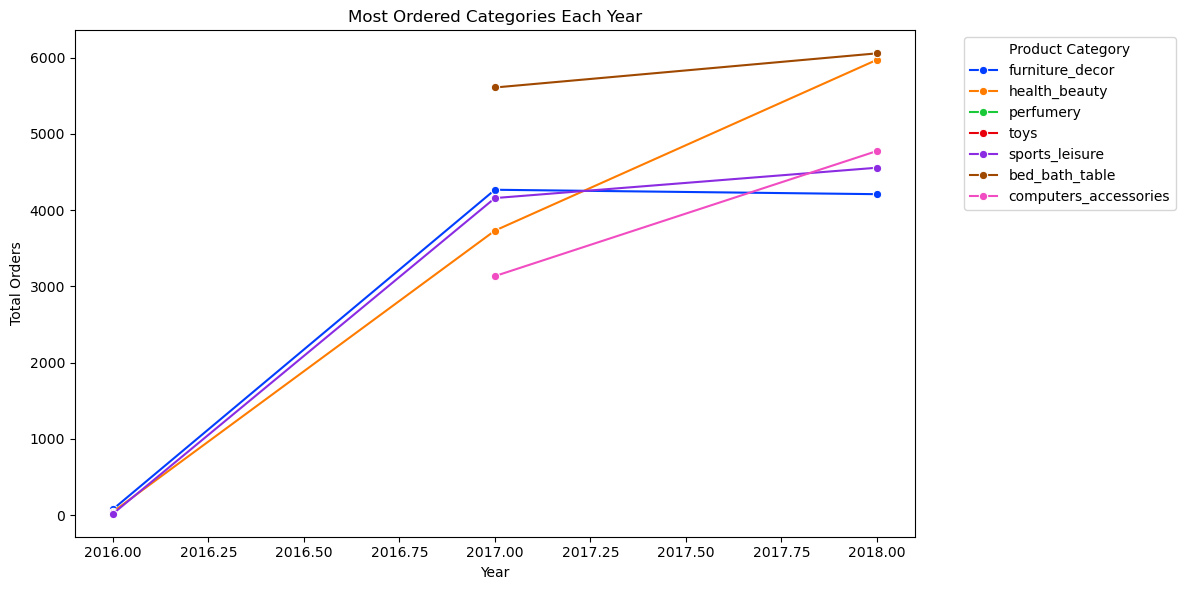

In [194]:
# Visualisasi perkembangan kategori per tahun
plt.figure(figsize=(12,6))
sns.lineplot(
    x='year',
    y='total_orders',
    hue='product_category_name_english',
    data=top_categories_per_year,
    marker='o',
    palette='bright'  # Ganti dengan 'husl' atau 'tab10' juga bisa
)
plt.xlabel("Year")
plt.ylabel("Total Orders")
plt.title("Most Ordered Categories Each Year")
plt.legend(title="Product Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Berdasarkan data ini, dapat dilihat tren dan perubahan dalam popularitas kategori produk dari tahun 2016 hingga 2018:

- Tahun 2016: Pada tahun ini data yang tersedia terbatas dan hanya menunjukkan furniture_decor sebagai kategori terpopuler dengan 76 order. Ini mungkin menunjukkan bahwa Olist baru memulai atau fokus pada kategori ini pada awal operasinya.

- Tahun 2017: Terjadi perubahan signifikan pada tahun 2017. bed_bath_table muncul sebagai kategori paling populer dengan 5610 order, menggeser furniture_decor ke posisi kedua dengan 4268 pesanan. Kategori sports_leisure juga masuk dalam 3 besar dengan 4159 pesanan. Ini menunjukkan bertambahnya variasi dan pertumbuhan penjualan di berbagai kategori produk.

- Tahun 2018: bed_bath_table tetap menjadi kategori paling populer di tahun 2018 dengan 6058 order, menunjukkan pertumbuhan yang konsisten. health_beauty naik ke posisi kedua dengan 5973 pesanan, dan computers_accessories posisi ketiga dengan 4776 order. Ini menunjukkan bahwa kategori health_beauty mengalami peningkatan popularitas yang signifikan sedangkan furniture_decor sebaliknya.

# STEP 8: Review Customer
1. What is the average review score for each customer and create a column for the satisfaction level of each customer assuming a score of 4 & 5 is satisfied, otherwise not satisfied
2. Select a customer who fills in the title and message review, then create a table to calculate the total reviews for each customer and combine it with the total order table to find information on the review ratio per transaction for each customer


1. What is the average review score for each customer and create a column for the satisfaction level of each customer assuming a score of 4 & 5 is satisfied, otherwise not satisfied

In [195]:
# Menghitung rata-rata review score per customer
avg_review_per_customer = df.groupby('customer_unique_id')['review_score'].mean().reset_index()
avg_review_per_customer.rename(columns={'review_score': 'avg_review_score'}, inplace=True)

# Menambahkan kolom kepuasan pelanggan
avg_review_per_customer['satisfaction_level'] = avg_review_per_customer['avg_review_score'].apply(
    lambda x: 'Satisfied' if x >= 4 else 'Not Satisfied'
)

In [196]:
# Melihat hasil
avg_review_per_customer.head()

,customer_unique_id,avg_review_score,satisfaction_level
0,0000366f3b9a7992bf8c76cfdf3221e2,5.0,Satisfied
1,0000b849f77a49e4a4ce2b2a4ca5be3f,4.0,Satisfied
2,0000f46a3911fa3c0805444483337064,3.0,Not Satisfied
3,0000f6ccb0745a6a4b88665a16c9f078,4.0,Satisfied
4,0004aac84e0df4da2b147fca70cf8255,5.0,Satisfied


In [197]:
# Klasifikasi kepuasan pelanggan
avg_review_per_customer['satisfaction_level'] = avg_review_per_customer['avg_review_score'].apply(lambda x: 'Satisfied' if x >= 4 else 'Not Satisfied')

# Hitung jumlah pelanggan dalam setiap kategori kepuasan
satisfaction_counts = avg_review_per_customer['satisfaction_level'].value_counts()

# Hitung persentase pelanggan yang puas dan tidak puas
satisfaction_percentage = (satisfaction_counts / satisfaction_counts.sum()) * 100

In [198]:
satisfaction_percentage

satisfaction_level
Satisfied        78.720217
Not Satisfied    21.279783
Name: count, dtype: float64

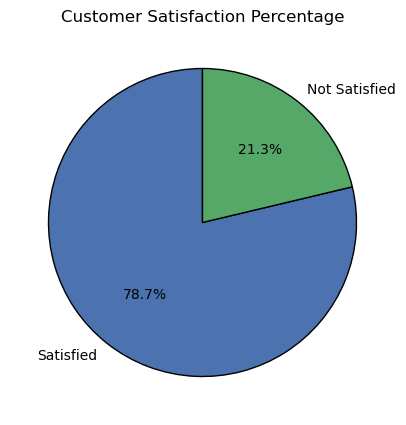

In [199]:
# Membuat pie chart untuk Customer Satisfaction Percentage
plt.figure(figsize=(8,5))
satisfaction_colors = ['#4c72b0', '#55a868']  # Biru dan Hijau 
satisfaction_percentage.plot(kind='pie', autopct='%1.1f%%', 
                             colors=satisfaction_colors, startangle=90, 
                             wedgeprops={'edgecolor': 'black'})
plt.ylabel("")
plt.title("Customer Satisfaction Percentage")
plt.show()

- Mayoritas customer (78.7%) merasa puas dengan pengalaman belanja mereka, menunjukkan bahwa layanan yang diberikan oleh platform secara umum berhasil memenuhi harapan konsumen.

- Namun, masih terdapat 21.3% customer yang tidak puas, yang merupakan proporsi yang cukup signifikan dan perlu menjadi perhatian. 

2. Select a customer who fills in the title and message review, then create a table to calculate the total reviews for each customer and combine it with the total order table to find information on the review ratio per transaction for each customer


In [200]:
total_reviews_per_customer = df.groupby('customer_unique_id')['review_score'].count().reset_index()
total_reviews_per_customer.rename(columns={'review_score': 'total_reviews'}, inplace=True)

In [201]:
total_reviews_per_customer

,customer_unique_id,total_reviews
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
91448,fffcf5a5ff07b0908bd4e2dbc735a684,2
91449,fffea47cd6d3cc0a88bd621562a9d061,1
91450,ffff371b4d645b6ecea244b27531430a,1
91451,ffff5962728ec6157033ef9805bacc48,1


In [202]:
# Memfilter data untuk memilih customer yang mengisi title dan message review
filtered_data = df[(df['review_comment_title'].notna()) & (df['review_comment_message'].notna())]

In [203]:
# Membuat tabel untuk menghitung total review untuk setiap customer
review_table = filtered_data.groupby('customer_id')['review_id'].count().reset_index()
review_table.columns = ['customer_id', 'total_reviews']

In [204]:
review_table

,customer_id,total_reviews
0,00012a2ce6f8dcda20d059ce98491703,1
1,000161a058600d5901f007fab4c27140,1
2,0001fd6190edaaf884bcaf3d49edf079,1
3,0002414f95344307404f0ace7a26f1d5,1
4,000379cdec625522490c315e70c7a9fb,1
...,...,...
94454,fffcb937e9dd47a13f05ecb8290f4d3e,1
94455,fffecc9f79fd8c764f843e9951b11341,3
94456,fffeda5b6d849fbd39689bb92087f431,1
94457,ffff42319e9b2d713724ae527742af25,1


In [205]:
# Membuat tabel untuk menghitung total order untuk setiap customer
order_table = df.groupby('customer_id')['order_id'].nunique().reset_index()
order_table.columns = ['customer_id', 'total_orders']

In [206]:
order_table

,customer_id,total_orders
0,00012a2ce6f8dcda20d059ce98491703,1
1,000161a058600d5901f007fab4c27140,1
2,0001fd6190edaaf884bcaf3d49edf079,1
3,0002414f95344307404f0ace7a26f1d5,1
4,000379cdec625522490c315e70c7a9fb,1
...,...,...
94454,fffcb937e9dd47a13f05ecb8290f4d3e,1
94455,fffecc9f79fd8c764f843e9951b11341,1
94456,fffeda5b6d849fbd39689bb92087f431,1
94457,ffff42319e9b2d713724ae527742af25,1


In [207]:
# Menggabungkan tabel review dan order
review_transaction_ratio_table = pd.merge(review_table, order_table, on='customer_id')

# Menghitung review ratio per transaction untuk setiap customer
review_transaction_ratio_table['review_ratio'] = review_transaction_ratio_table['total_reviews'] / review_transaction_ratio_table['total_orders']

In [208]:
# Melihat hasil
review_transaction_ratio_table

,customer_id,total_reviews,total_orders,review_ratio
0,00012a2ce6f8dcda20d059ce98491703,1,1,1.0
1,000161a058600d5901f007fab4c27140,1,1,1.0
2,0001fd6190edaaf884bcaf3d49edf079,1,1,1.0
3,0002414f95344307404f0ace7a26f1d5,1,1,1.0
4,000379cdec625522490c315e70c7a9fb,1,1,1.0
...,...,...,...,...
94454,fffcb937e9dd47a13f05ecb8290f4d3e,1,1,1.0
94455,fffecc9f79fd8c764f843e9951b11341,3,1,3.0
94456,fffeda5b6d849fbd39689bb92087f431,1,1,1.0
94457,ffff42319e9b2d713724ae527742af25,1,1,1.0


In [209]:
# Menampilkan distribusi nilai review_score
# ini akan menampilkan berapa banyak setiap nilai review_score muncul dalam dataset
df['review_score'].value_counts()

review_score
5    65139
4    21811
1    12861
3     9528
2     3839
Name: count, dtype: int64

In [210]:
# Melihat hasil
total_reviews_per_customer.head()

,customer_unique_id,total_reviews
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1


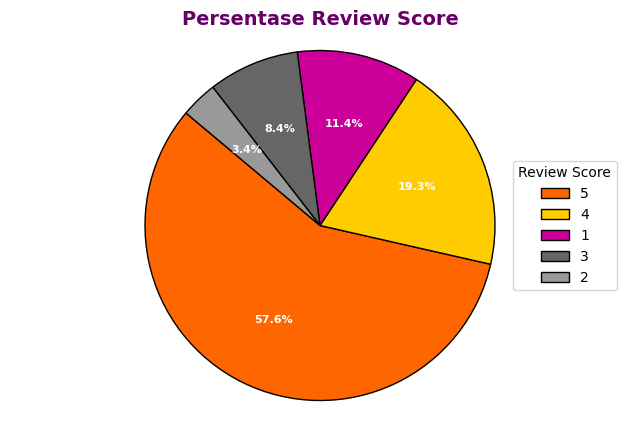

In [211]:
# Menghitung distribusi review_score dalam persen
review_counts = df['review_score'].value_counts()
review_percent = (review_counts / review_counts.sum()) * 100

# Warna sesuai dengan contoh gambar
colors = ['#ff6600', '#ffcc00', '#cc0099', '#666666', '#999999']

# Membuat pie chart
fig, ax = plt.subplots(figsize=(8, 5))
wedges, texts, autotexts = ax.pie(
    review_percent, labels=review_percent.index, autopct='%1.1f%%',
    colors=colors[:len(review_percent)], startangle=140, wedgeprops={'edgecolor': 'black'},
    textprops={'fontsize': 8, 'color': 'white', 'weight': 'bold'}
)

# Menambahkan legenda di sisi kanan
ax.legend(wedges, review_percent.index, title="Review Score", loc="center left", bbox_to_anchor=(0.8, 0.5))

# Menambahkan judul dengan warna dan gaya seperti contoh
plt.title('Persentase Review Score', fontsize=14, fontweight='bold', color='#660066')
plt.axis('equal')  # Menjaga aspek ratio lingkaran
plt.show()

Analisis kepuasan pelanggan kami menunjukkan hasil yang sangat positif. Sebagian besar customer, yakni 57,6%, memberikan penilaian tertinggi dengan skor 5 (sangat puas). Sementara itu, 19,3% customer memberikan nilai 4, dan 11,4% memberikan nilai 1. Kategori penilaian menengah yaitu skor 3 dan 2 masing-masing mendapat persentase yang lebih kecil, sebesar 8,4% dan 3,4%. Data ini mengindikasikan bahwa mayoritas pelanggan kita sangat puas dengan produk/layanan yang diberikan, meskipun masih ada ruang perbaikan untuk mengurangi persentase pelanggan yang memberikan nilai rendah.

# STEP 9: Time Series Analysis
1. Time series analysis is an analysis to see the trend of a phenomenon based on time. Try totaling the sales of each item per day. What are the sales trends? Is there an increase, decrease, or stagnant. What should business do?
2. Perform a seasonality analysis by looking at the total orders per day from Monday to Sunday.


1. Time series analysis is an analysis to see the trend of a phenomenon based on time. Try totaling the sales of each item per day. What are the sales trends? Is there an increase, decrease, or stagnant. What should business do?


In [212]:
# Menghitung total penjualan per hari
daily_sales = df.groupby(df['order_purchase_timestamp'].dt.date)['price'].sum().reset_index()
daily_sales.rename(columns={'order_purchase_timestamp': 'date', 'price': 'total_sales'}, inplace=True)

In [213]:
daily_sales

,date,total_sales
0,2016-10-03,441.98
1,2016-10-04,9093.20
2,2016-10-05,6329.57
3,2016-10-06,5889.96
4,2016-10-07,5955.35
...,...,...
606,2018-08-25,10711.93
607,2018-08-26,8235.71
608,2018-08-27,4825.87
609,2018-08-28,3757.51


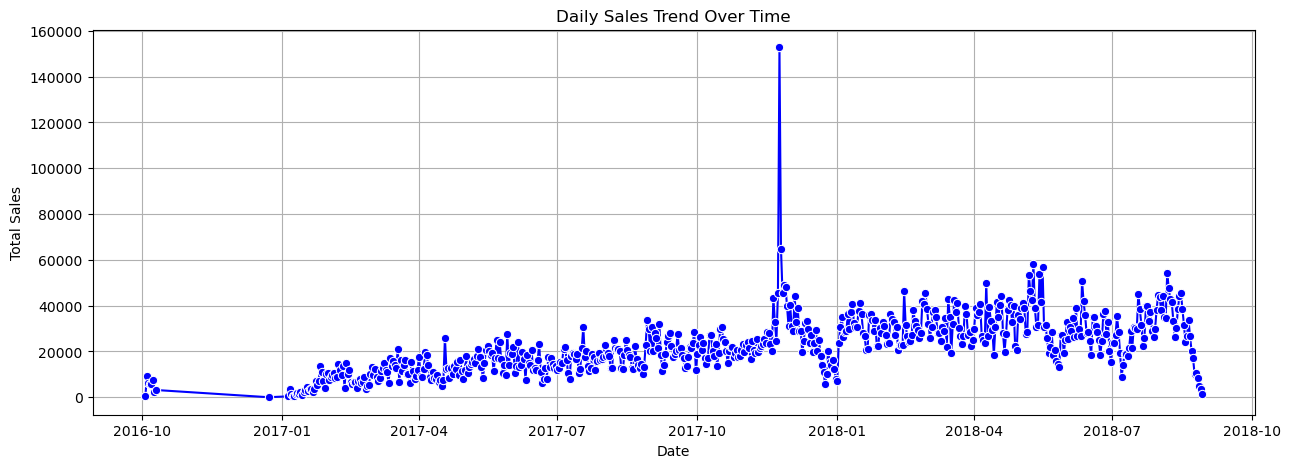

In [214]:
# Konversi kolom date ke format datetime
daily_sales['date'] = pd.to_datetime(daily_sales['date'])

# Visualisasi tren penjualan harian
plt.figure(figsize=(15, 5))
sns.lineplot(x='date', y='total_sales', data=daily_sales, marker='o', color='b')
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.title("Daily Sales Trend Over Time")
plt.grid(True)
plt.show()

- Berdasarkan grafik tren penjualan harian dari Oktober 2016 hingga Oktober 2018, terlihat adanya peningkatan jumlah penjualan secara bertahap dengan lonjakan signifikan sekitar November 2017 hingga Januari 2018. Setelah periode lonjakan tersebut, penjualan kembali menurun dan cenderung fluktuatif namun berada di level yang lebih tinggi dibandingkan sebelum November 2017.

- Jadi, tren penjualan menunjukkan adanya peningkatan secara keseluruhan dalam periode waktu tersebut, dengan puncak yang sangat tinggi di sekitar akhir tahun 2017 dan awal tahun 2018.

- Apa yang sebaiknya dilakukan bisnis:

    - Identifikasi atau disampaikan kepada stakeholder apa penyebab lonjakan penjualan: ini sangat penting untuk memahami mengapa terjadi lonjakan penjualan yang signifikan pada November 2017 hingga Januari 2018. Apakah ini disebabkan oleh:

        - Promosi atau Diskon Khusus: Apakah ada kampanye promosi besar-besaran atau periode diskon pada waktu tersebut?
        - Faktor Musiman: Apakah produk atau layanan bisnis Anda cenderung mengalami peningkatan permintaan di akhir tahun atau musim liburan?
        - Tren Pasar: Apakah ada tren pasar atau peristiwa tertentu yang mendorong peningkatan penjualan?
        - Peluncuran Produk Baru: Apakah ada produk atau layanan baru yang diluncurkan sekitar waktu tersebut?
        - Aktivitas Pemasaran: Apakah ada peningkatan aktivitas pemasaran yang signifikan?

- Setelah itu manfaatkan pembelajaran dari lonjakan: Setelah mengidentifikasi penyebab lonjakan, bisnis dapat mencoba untuk  mengadaptasi strategi tersebut di masa depan. Misalnya, jika promosi akhir tahun menjadi pendorong utama, bisnis dapat merencanakan promosi serupa untuk tahun-tahun berikutnya.

2. Perform a seasonality analysis by looking at the total orders per day from Monday to Sunday.


In [216]:
# Menghitung total order per hari dalam seminggu
weekday_sales = df.groupby('day')['order_id'].count().reset_index()
weekday_sales.rename(columns={'order_id': 'total_orders'}, inplace=True)

# Menyusun hari agar urut dari Senin - Minggu
order_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_sales['day'] = pd.Categorical(weekday_sales['day'], categories=order_days, ordered=True)
weekday_sales = weekday_sales.sort_values('day')

In [217]:
weekday_sales

,day,total_orders
1,Monday,18365
5,Tuesday,18404
6,Wednesday,17671
4,Thursday,16906
0,Friday,16184
2,Saturday,12202
3,Sunday,13446


C:\Users\W10\AppData\Local\Temp\ipykernel_1092\3778030741.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='day', y='total_orders', data=weekday_sales, palette='coolwarm')


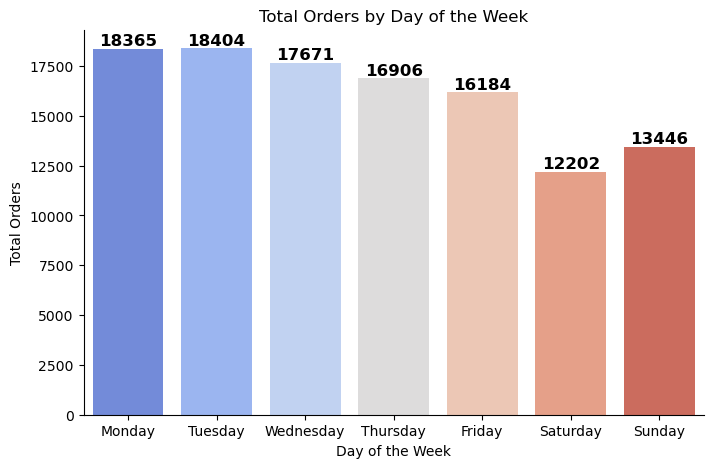

In [218]:
# Membuat figure
plt.figure(figsize=(8, 5))

# Membuat barplot
ax = sns.barplot(x='day', y='total_orders', data=weekday_sales, palette='coolwarm')

# Menambahkan angka di atas setiap batang
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# Menghilangkan garis belakang (spines)
sns.despine()

# Menambahkan label dan judul
plt.xlabel("Day of the Week")
plt.ylabel("Total Orders")
plt.title("Total Orders by Day of the Week")

# Menampilkan plot
plt.show()


### Kesimpulan 
"Grafik ini menunjukkan jumlah total pesanan berdasarkan hari dalam seminggu. Terlihat bahwa pemesanan cenderung lebih tinggi pada hari Senin hingga Rabu, dan mulai menurun pada akhir pekan, dengan jumlah pesanan terendah terjadi pada hari Sabtu."


# STEP 10: Create your own visualization and business presentation! 
- Include :  
- Background 
- Objective
- Data Explanation
- Analysis
- Suggestions/Conclusions/Recommendations


### Background

OLIST adalah marketplace besar di Brasil yang menghubungkan bisnis kecil dan menengah dengan platform e-commerce besar.

### Objective

- Menganalisis demografi pelanggan.

- Menganalisis perilaku pemesanan.

- Menganalisis ulasan pelanggan.

- Melakukan analisis deret waktu.

##  Kesimpulan Umum (Conclusions)

### Sebaran Customer
- Customer Olist sebagian besar terkonsentrasi di negara bagian **Sao Paulo** dan kota besar lainnya seperti **Rio de Janeiro**.
- Distribusi customer **tidak merata**, menunjukkan bahwa **penetrasi pasar Olist masih terbatas** pada wilayah-wilayah tertentu.

###  Perilaku Pemesanan
- Mayoritas customer hanya melakukan **satu kali pembelian**, dengan sangat sedikit customer yang berbelanja secara rutin.
- Aktivitas pembelian tertinggi terjadi pada **bulan Juli** dan **hari kerja (Senin–Rabu)**, serta pada **sore hari- malam hari**.

###  Kualitas Produk dan Layanan
- Sebagian besar customer merasa **puas** dengan pengalaman belanja mereka (**skor review 4 dan 5**), menunjukkan bahwa kualitas produk dan layanan sudah cukup baik.
- Namun, masih ada sekitar **12% customer yang memberikan skor rendah (1 dan 2)**, yang menunjukkan adanya **ruang untuk perbaikan**.

###  Kategori dan Harga Produk
- Produk dengan **harga murah lebih sering dibeli**, menunjukkan bahwa mayoritas customer **sensitif terhadap harga**.
- Kategori populer seperti **bed_bath_table**, **health_beauty**, dan **furniture_decor** menunjukkan **tren positif dari tahun ke tahun**.

###  Metode Pembayaran
- **Kartu kredit** merupakan metode pembayaran paling populer, menandakan preferensi customer terhadap transaksi yang **cepat dan fleksibel**.

###  Tren Penjualan
- Penjualan menunjukkan **peningkatan signifikan pada akhir tahun 2017 hingga awal 2018**, kemungkinan besar dipengaruhi oleh **faktor musiman** seperti liburan atau promosi akhir tahun.
- Setelah periode tersebut, penjualan tetap tinggi meskipun **sedikit fluktuatif**.

---

##  Saran dan Rekomendasi (Suggestions & Recommendations)

### Strategi Retensi Customer
- Lakukan pendekatan khusus kepada customer **yang hanya bertransaksi satu kali**, misalnya melalui **email marketing** dengan diskon eksklusif atau penawaran produk serupa untuk **mendorong repeat order**.
- Buat program **loyalitas** atau **reward** untuk customer yang sering berbelanja agar meningkatkan **retensi customer**.

### Prioritas Target Pasar
- Fokus pada kota-kota yang tinggi: Mengingat mayoritas pelanggan berasal dari Sao Paulo dan Rio de Janeiro, tetapi penjualan perlu memperluas jangkauan pemasaran ke kota-kota lain di Brasil. 
- Riset pasar mendalam: Lakukan riset pasar yang mendalam untuk memahami preferensi dan kebutuhan konsumen di berbagai wilayah.

### Optimalisasi Momen Musiman
- Manfaatkan momen yang menyebabkan **lonjakan penjualan di akhir tahun 2017** dengan perencanaan kampanye promosi besar (**Black Friday, Tahun Baru**, dll).
- Siapkan **stok dan logistik lebih awal** untuk mengantisipasi lonjakan tersebut.

### Evaluasi Produk & Kualitas Layanan
- **Analisis lebih lanjut** terhadap ulasan dengan **skor rendah** untuk mengidentifikasi **produk atau penjual yang sering bermasalah**.
- Tingkatkan **kontrol kualitas** dan **layanan customer** agar angka ketidakpuasan menurun.

### Segmentasi Harga dan Produk
- Mengingat mayoritas customer memilih **produk dengan harga murah**, sediakan lebih banyak **variasi produk dengan harga terjangkau**, tanpa mengorbankan kualitas.
- Fokus pada kategori populer: Tingkatkan stok dan promosi untuk kategori produk yang mengalami peningkatan penjualan, yaitu bed_bath_table,  health_beauty, dan furniture_decor.
- Diversifikasi produk: Pertimbangkan untuk memperluas jangkauan produk untuk memenuhi kebutuhan pelanggan yang beragam.
- Untuk meningkatkan **nilai transaksi**, tawarkan **bundling produk** atau **upselling** untuk kategori tertentu.

### Optimalisasi Waktu Operasional
- Perkuat layanan di **jam-jam dan hari sibuk (Senin–Rabu, siang hari-malam hari)** dengan mempercepat **proses pengemasan dan pengiriman**.

### Diversifikasi Metode Pembayaran
- Meski **kartu kredit mendominasi**, tetap sediakan berbagai metode pembayaran lain yang populer di wilayah tertentu untuk menjangkau lebih banyak segmen customer, misalnya **e-wallet** atau **COD (Cash on Delivery)**.
